### Visualize

In [1]:
import os
import torch
import pickle
import copy
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
def nested_defaultdict():
    return defaultdict(list)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from fairseq.checkpoint_utils import torch_persistent_save


def calculate_iou_from_sets(set_a,set_b):
    # Calculate the Intersection and Union
    intersection = set_a.intersection(set_b)
    union = set_a.union(set_b)

    # Calculate the Intersection over Union (IoU) score
    iou_score = len(intersection) / len(union)
    return iou_score

def cumulative_neuron_activation_indices_torch(activations, k):

    # Calculate the target number of activations (k percent of total)
    target_activations = activations.sum() * (k / 100)

    # Sort the activations in descending order and get the indices
    sorted_activations, indices = torch.sort(activations, descending=True)

    # Compute the cumulative sum of sorted activations
    cumsum_activations = torch.cumsum(sorted_activations, dim=0)

    # Find the index where cumulative sum reaches or exceeds the target activations
    target_index = torch.where(cumsum_activations >= target_activations)[0][0] + 1

    # Get the original indices of the neurons up to the target index
    neuron_indices = indices[:target_index]

    return neuron_indices

def load_masks(l,dir):
    masks = {}
    for i in os.listdir(dir):
        pair = i.split('.')[0]
        masks[pair] = torch.load(dir+'/'+i)
    return masks

l = ["de", "nl", "fr", "es", "ru", "cs", "hi", "bn", "ar", "he",
     "sv", "da", "it", "pt", "pl", "bg", "kn", "mr", "ha", "mt",
     "af", "lb", "ro", "oc", "uk", "sr", "sd", "gu", "ti", "am"]

high = ["de", "nl", "fr", "es", "ru", "cs", "hi", "bn", "ar", "he"]
med = ["sv", "da", "it", "pt", "pl", "bg", "kn", "mr", "ha", "mt"]
low = ["af", "lb", "ro", "oc", "uk", "sr", "sd", "gu", "ti", "am"]

2025-03-10 21:04:15 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


In [2]:
import os
import torch
import pickle
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
def nested_defaultdict():
    return defaultdict(list)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from fairseq.checkpoint_utils import torch_persistent_save

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

def load_act(lang_pair,dir):
    with open(dir+'/{}/activations.pkl'.format(lang_pair), "rb") as pickle_file:
        act = pickle.load(pickle_file)
    return act

def calculate_iou_from_sets(set_a,set_b):
    # Calculate the Intersection and Union
    intersection = set_a.intersection(set_b)
    union = set_a.union(set_b)

    # Calculate the Intersection over Union (IoU) score
    iou_score = len(intersection) / len(union)
    return iou_score

def cumulative_neuron_activation_indices_torch(activations, k):

    # Calculate the target number of activations (k percent of total)
    target_activations = activations.sum() * (k / 100)

    # Sort the activations in descending order and get the indices
    sorted_activations, indices = torch.sort(activations, descending=True)

    # Compute the cumulative sum of sorted activations
    cumsum_activations = torch.cumsum(sorted_activations, dim=0)

    # Find the index where cumulative sum reaches or exceeds the target activations
    target_index = torch.where(cumsum_activations >= target_activations)[0][0] + 1

    # Get the original indices of the neurons up to the target index
    neuron_indices = indices[:target_index]

    return neuron_indices

def load_neurons(l,dir):
    neurons = {}
    for i in l:
        pair = 'en-'+i
        neurons[pair] = load_act(pair,dir)
        pair = i+'-en'
        neurons[pair] = load_act(pair,dir)
    return neurons

In [3]:
def get_ready(k):
    dir='Neuron-Specialization/scripts/mT-big-NS/acts'
    neurons=load_neurons(l,dir)

    # neuron 2 weight
    default = torch.arange(4096)
    top_k_neurons = defaultdict(nested_defaultdict)
    neurons_new = defaultdict(nested_defaultdict)
    for lp in neurons:
        for layer in neurons[lp]:
            x = cumulative_neuron_activation_indices_torch(neurons[lp][layer], k)
            top_k_neurons[lp][layer] = x
            neurons_new[lp][layer] = torch.isin(default, x).int()

    neuron_2_weight = defaultdict(nested_defaultdict)
    for lp in neurons_new:
        for layer in neurons_new[lp]:
            neuron_2_weight[lp][layer] =  neurons_new[lp][layer].unsqueeze(1).expand([4096,1024]).bool()

    # visualize sparsity
    layers = list(neurons_new['en-de'].keys())
    lps = list(neurons_new.keys())
    df = pd.DataFrame(columns=['pair', 'sparsity', 'layer'])
    for layer in layers:
        for lp in lps:
            src,tgt = lp.split('-')
            if src=='en':
                type='en2x'
            else:
                type='x2en'
            s = (1-torch.count_nonzero(neurons_new[lp][layer])/4096).item()
            df = pd.concat([df,pd.DataFrame.from_dict([{'pair': lp, 
                                                        'type': type,
                                                        'layer': '_'.join(layer.split('oder_layer_')), 
                                                        'sparsity': s}])])

    sns.lineplot(df, x='layer', y='sparsity', hue='type')
    plt.xticks(rotation=45)
    plt.axvline(x = 5.5,  
                linestyle = "--", c='black') 
    plt.title('Sparsity of different fc1 layers over all language pairs')
    
    print(f'{n_layers}-layer model, creating the corresponding mask format (if your arch is not tradition transformer, check this part)')
    template = generate_weight_format(n_layers=6)
    weight = defaultdict(nested_defaultdict)
    for lp in neuron_2_weight:
        for key in template:
            if key!='encoder.version':
                if 'fc1' in key:
                    weight[lp][key] = neuron_2_weight[lp]['_'.join(key.split('.')[:3]).replace('layers', 'layer')]
    return weight

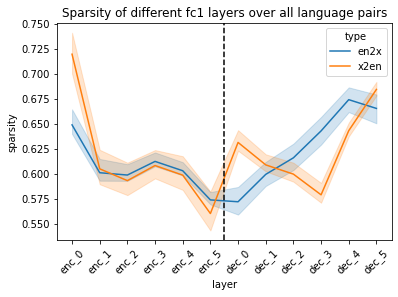

In [4]:
masks = get_ready(k=70)

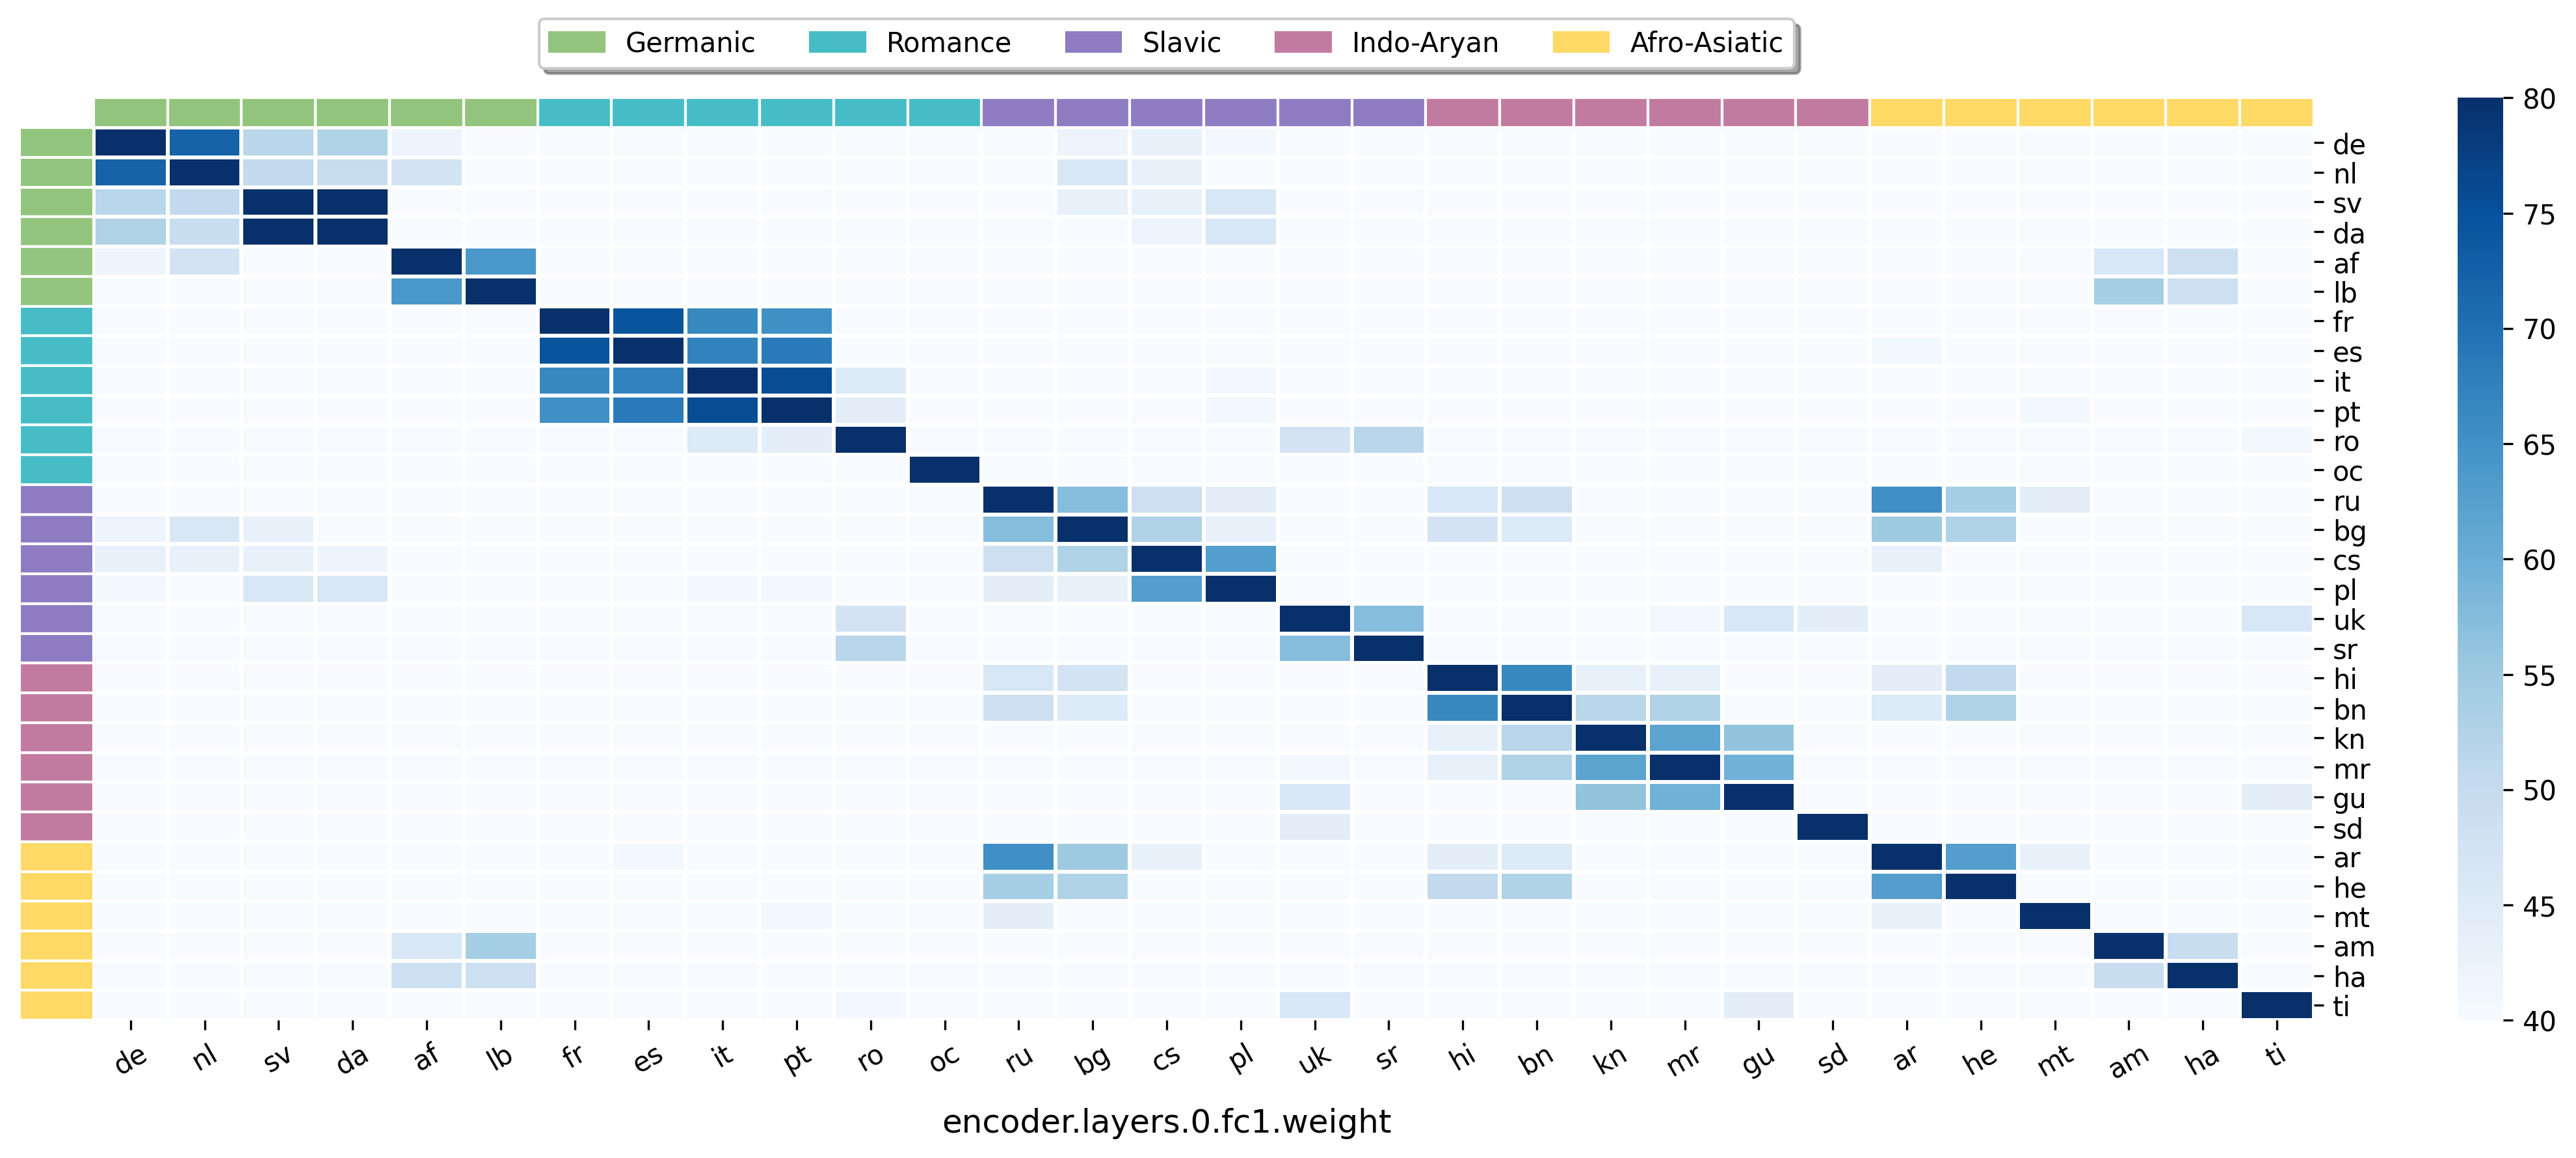

37.0  , 39.75555555555555
36.0  , 37.67816091954023


In [11]:
enc_ious = []
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

l_w = [
    ' ',
    "de", "nl", "sv", "da", "af", "lb",
    "fr", "es", "it", "pt", "ro", "oc",
    "ru", "bg", "cs", "pl", "uk", "sr",
    "hi", "bn", "kn", "mr", "gu", "sd", 
    "ar", "he", "mt", "ha", "am", "ti"
    ]

l = [
    "de", "nl", "sv", "da", "af", "lb",
    "fr", "es", "it", "pt", "ro", "oc",
    "ru", "bg", "cs", "pl", "uk", "sr",
    "hi", "bn", "kn", "mr", "gu", "sd", 
    "ar", "he", "mt", "am", "ha", "ti"
    ]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

#for i, layer in enumerate([j for j in masks['en-de'].keys() if 'fc1' in j]):

layer = 'encoder.layers.0.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks[src+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks[tgt+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个



germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()


print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
enc_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

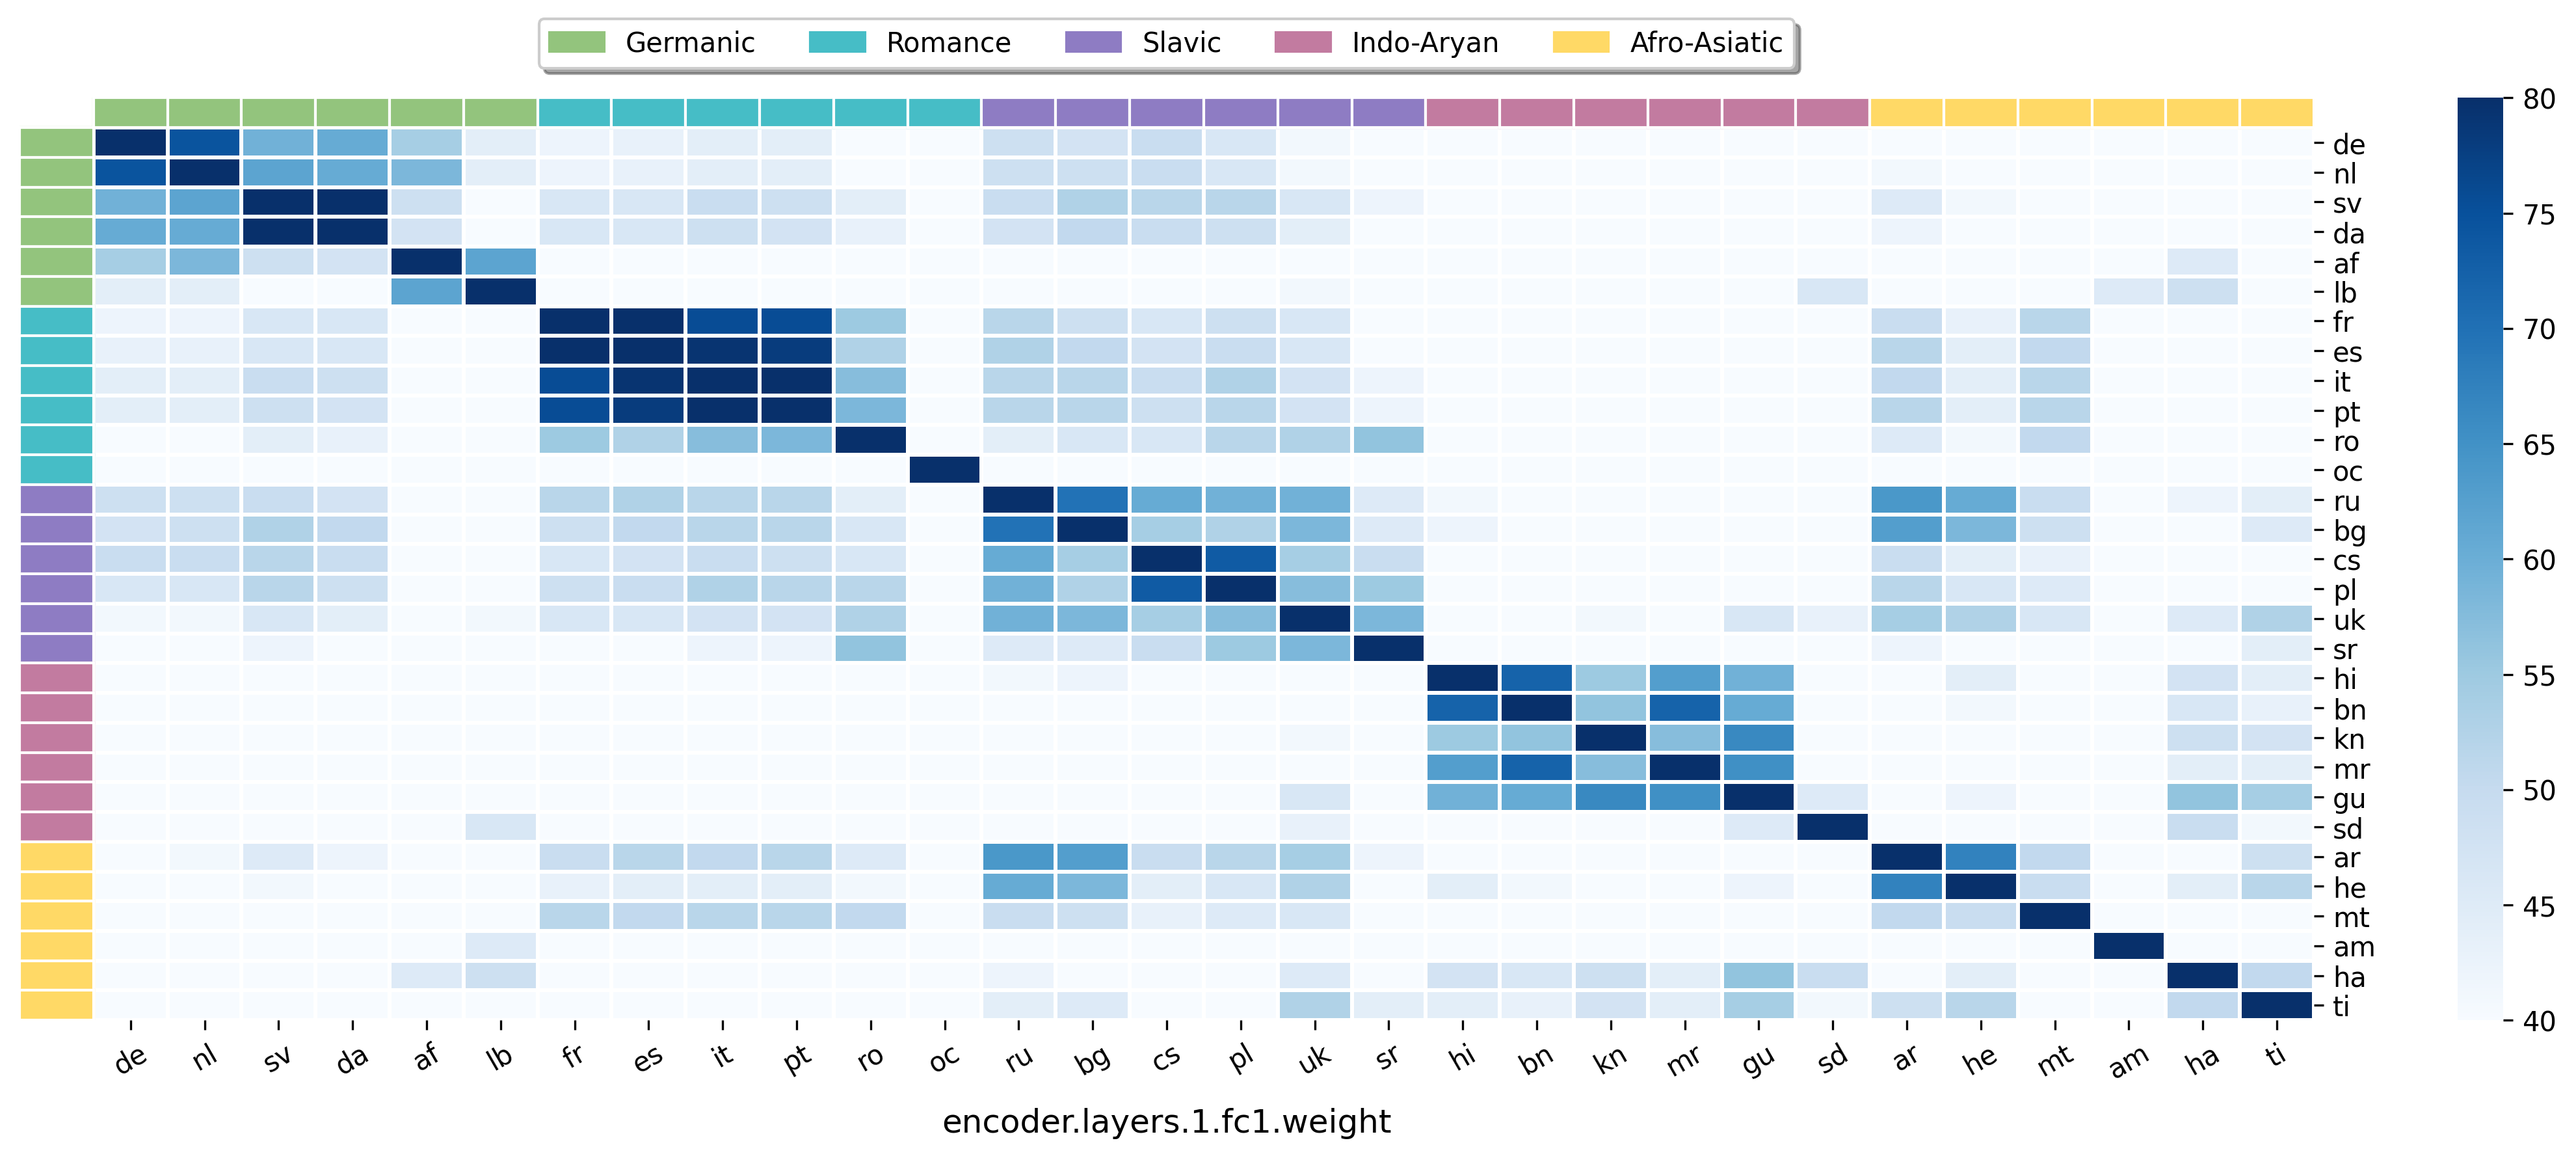

47.0  , 49.67333333333333
47.0  , 47.93793103448276


In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'encoder.layers.1.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks[src+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks[tgt+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个



germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
enc_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

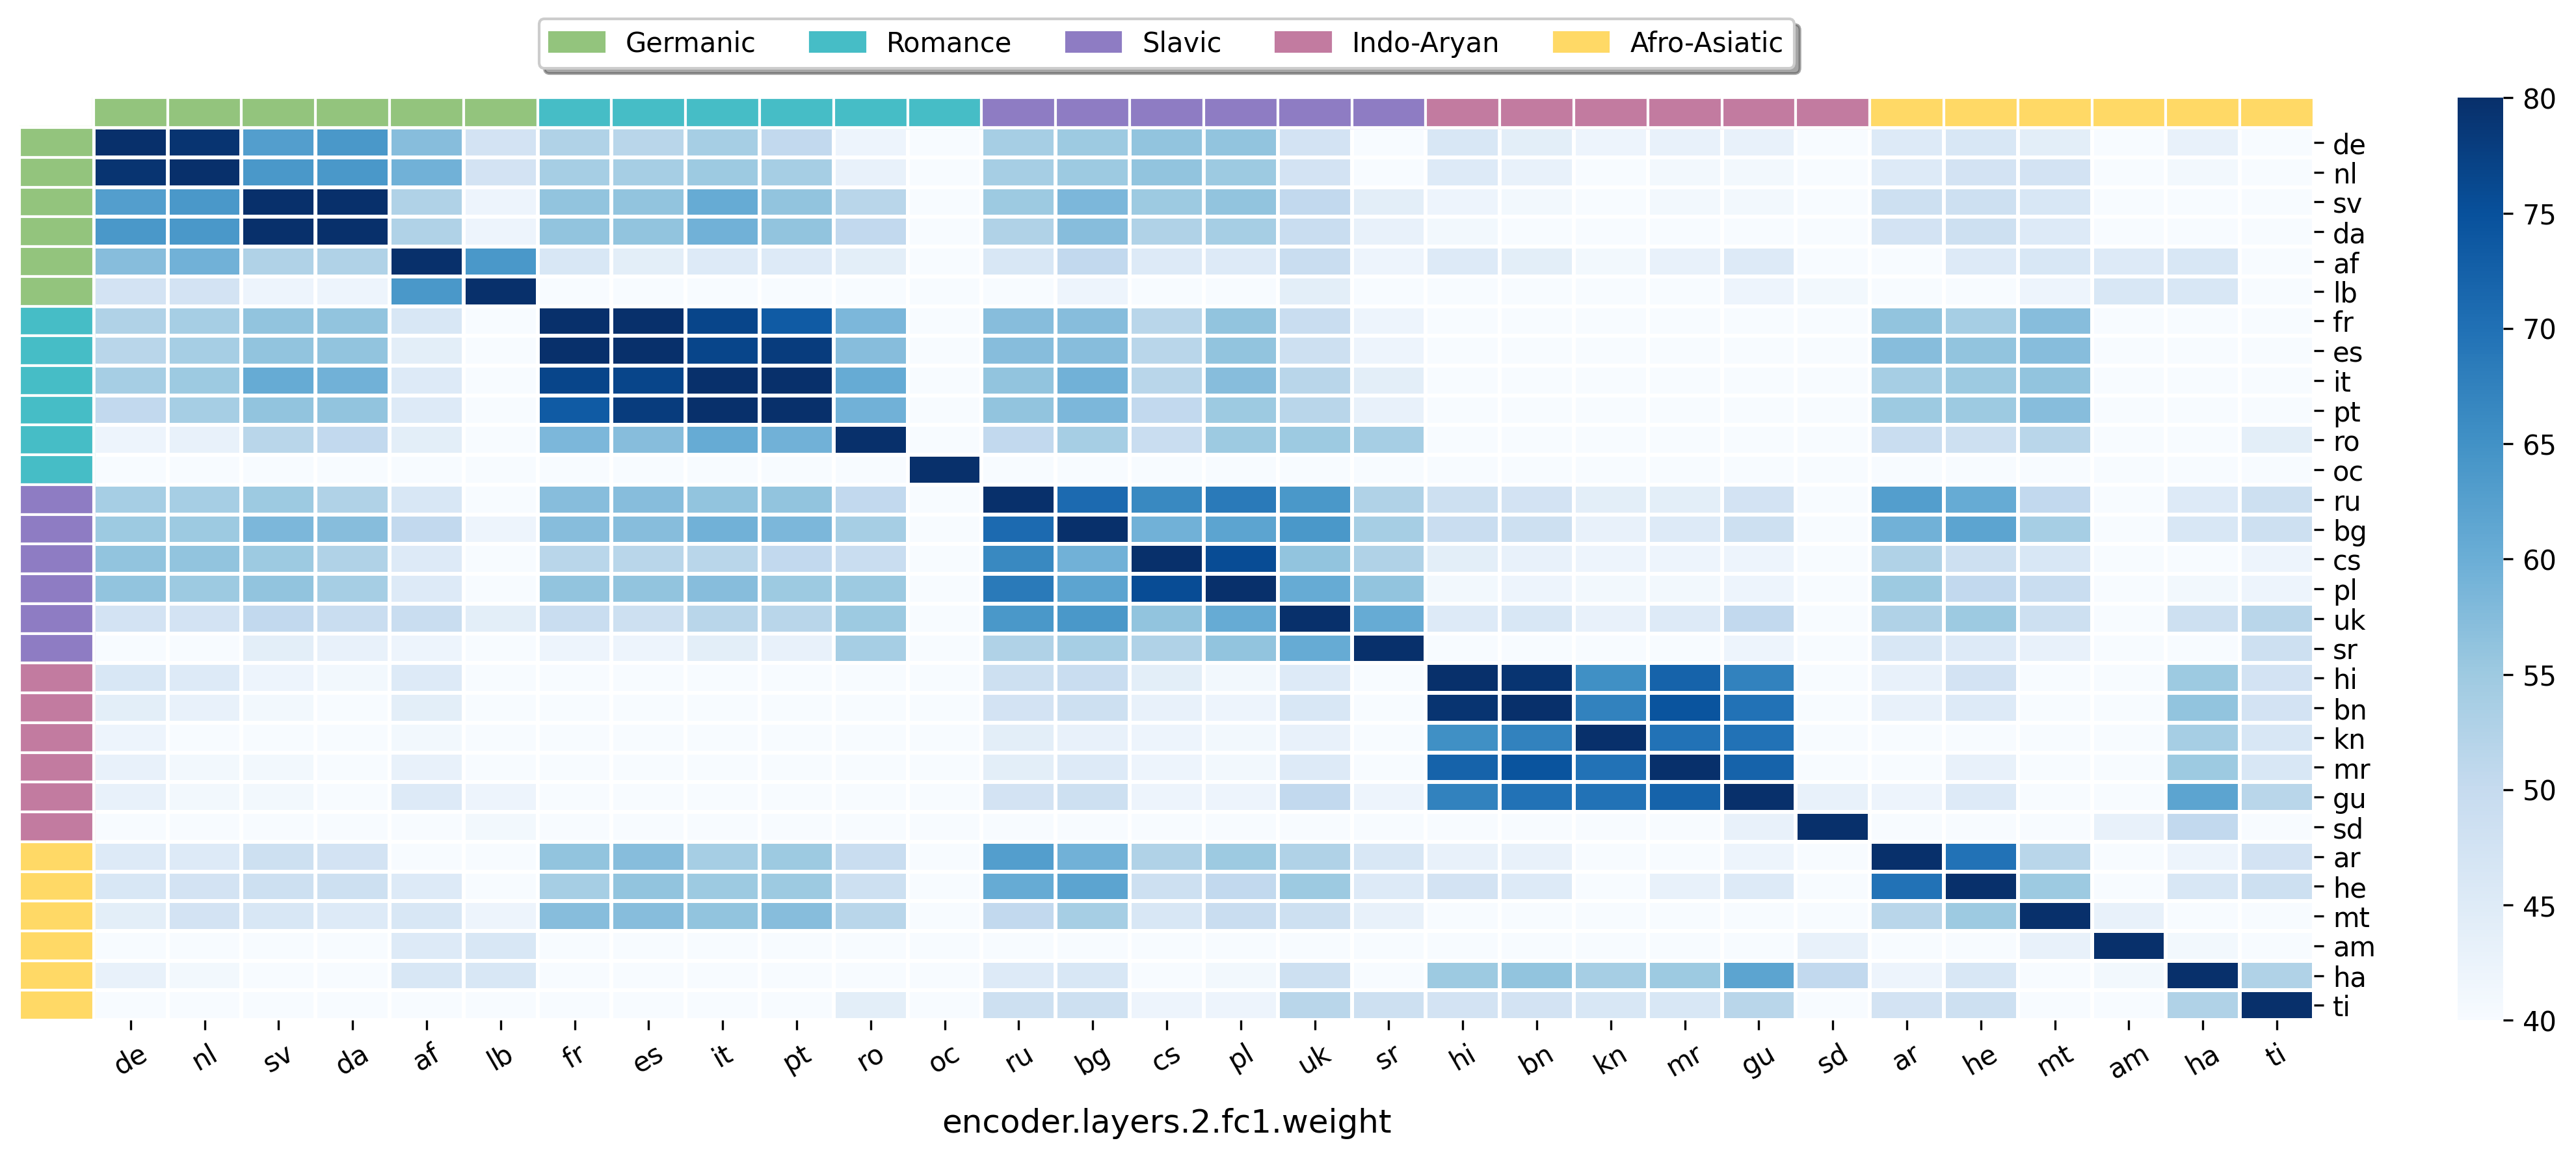

53.0  , 54.18888888888889
52.0  , 52.60919540229885


In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'encoder.layers.2.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks[src+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks[tgt+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个



germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
enc_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

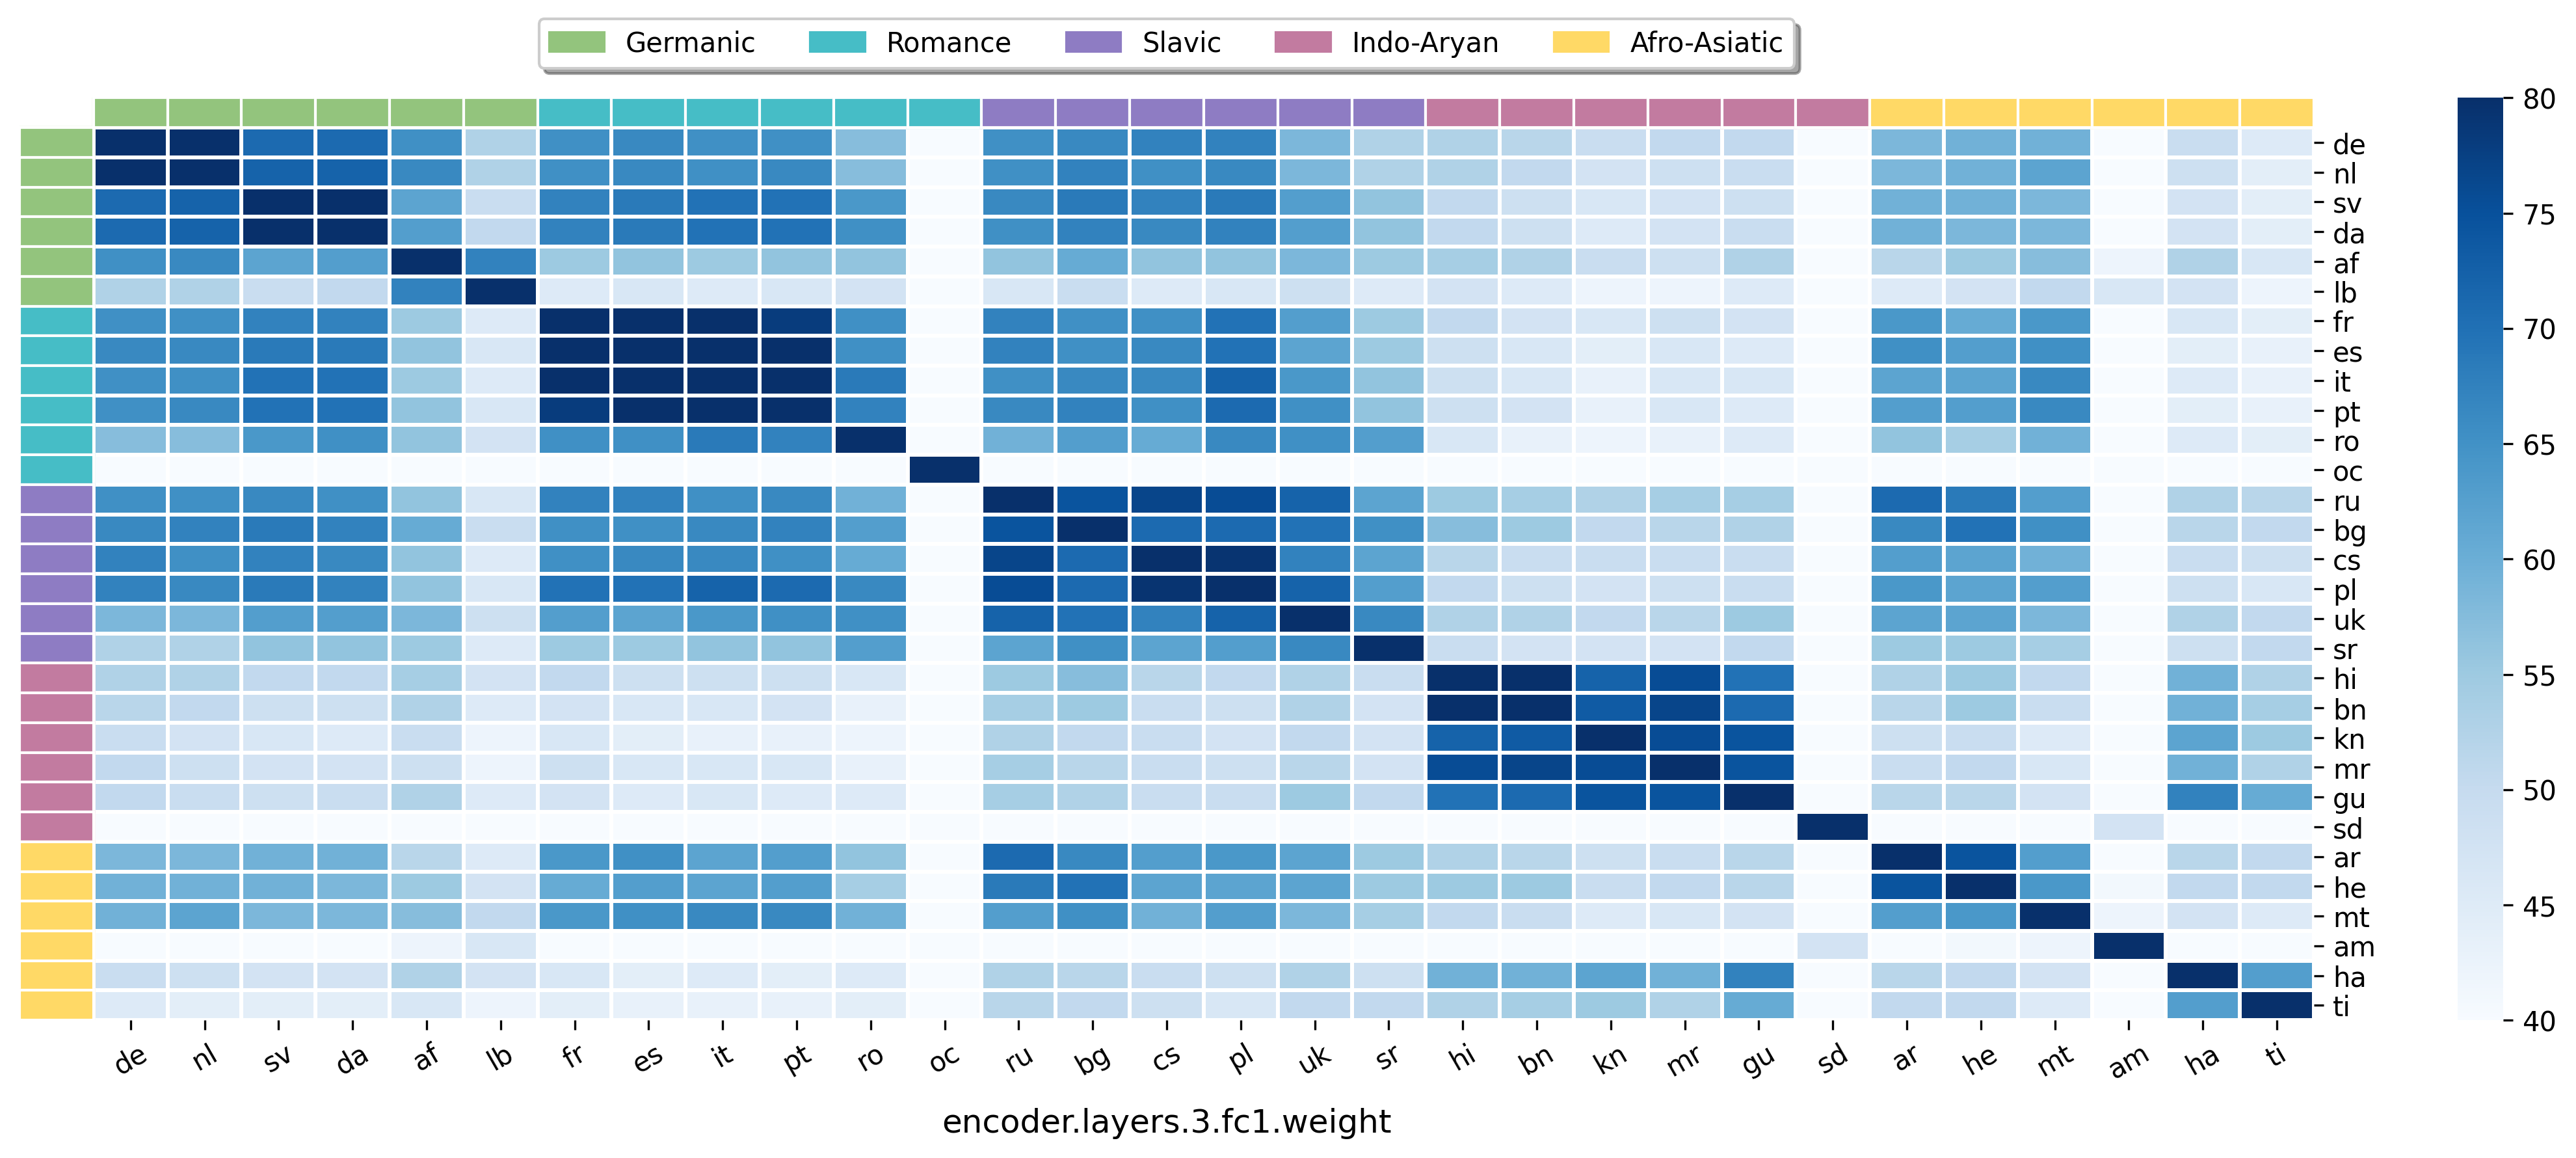

60.0  , 60.44444444444444
59.0  , 59.08045977011494


In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'encoder.layers.3.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks[src+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks[tgt+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个



germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
enc_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

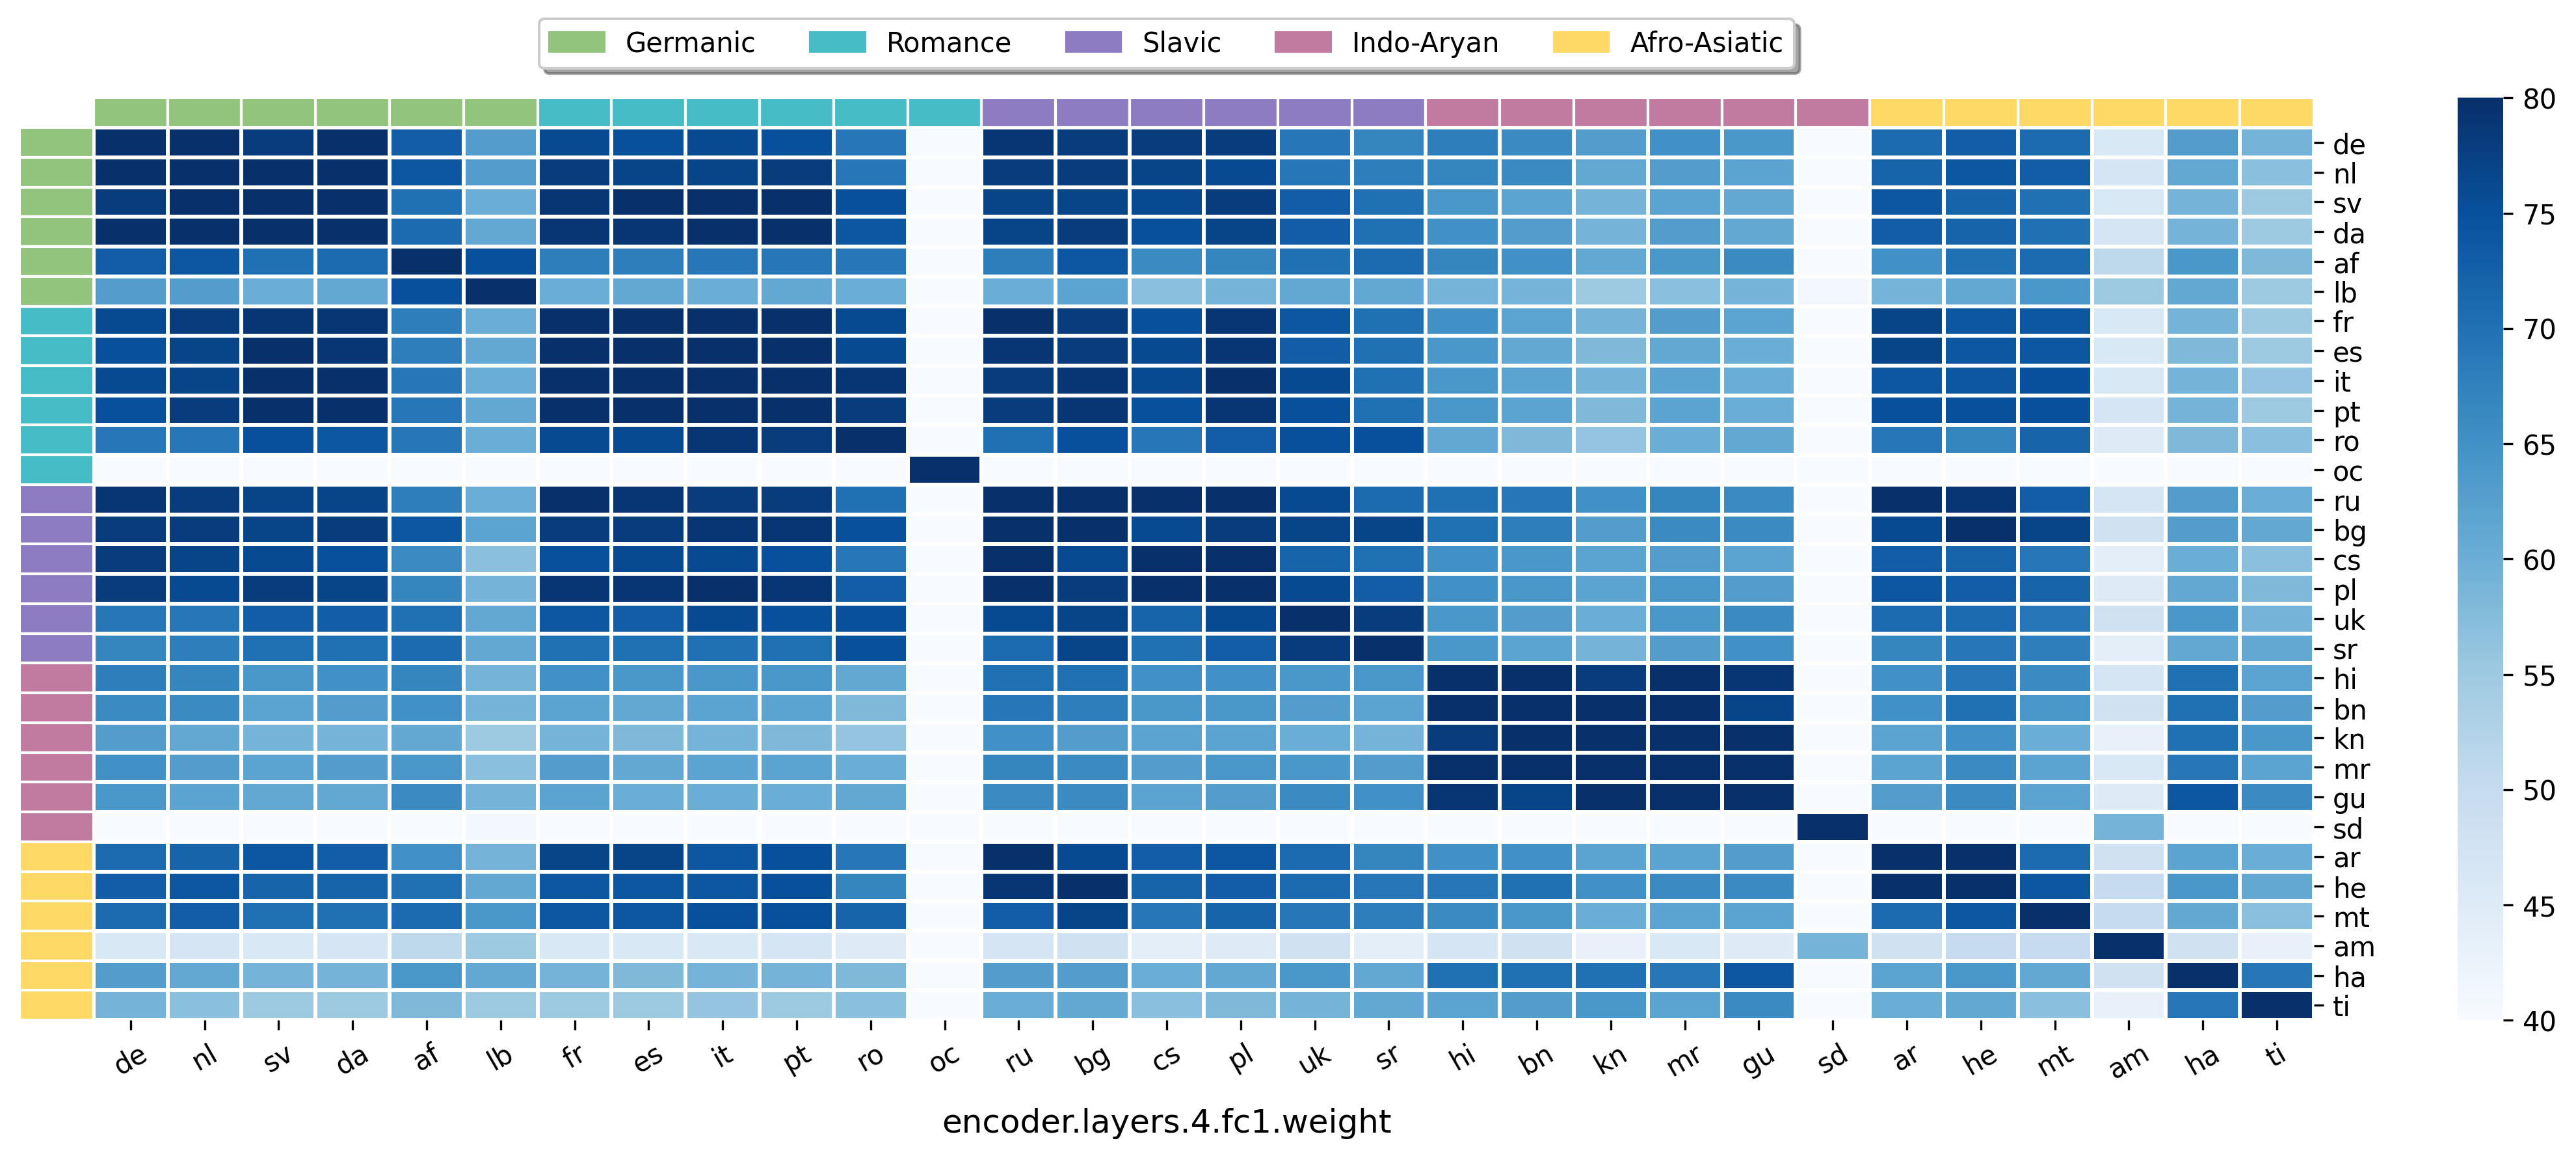

65.0  , 64.24444444444444
65.0  , 63.01149425287356


In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'encoder.layers.4.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks[src+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks[tgt+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
#df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个



germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()


print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
enc_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

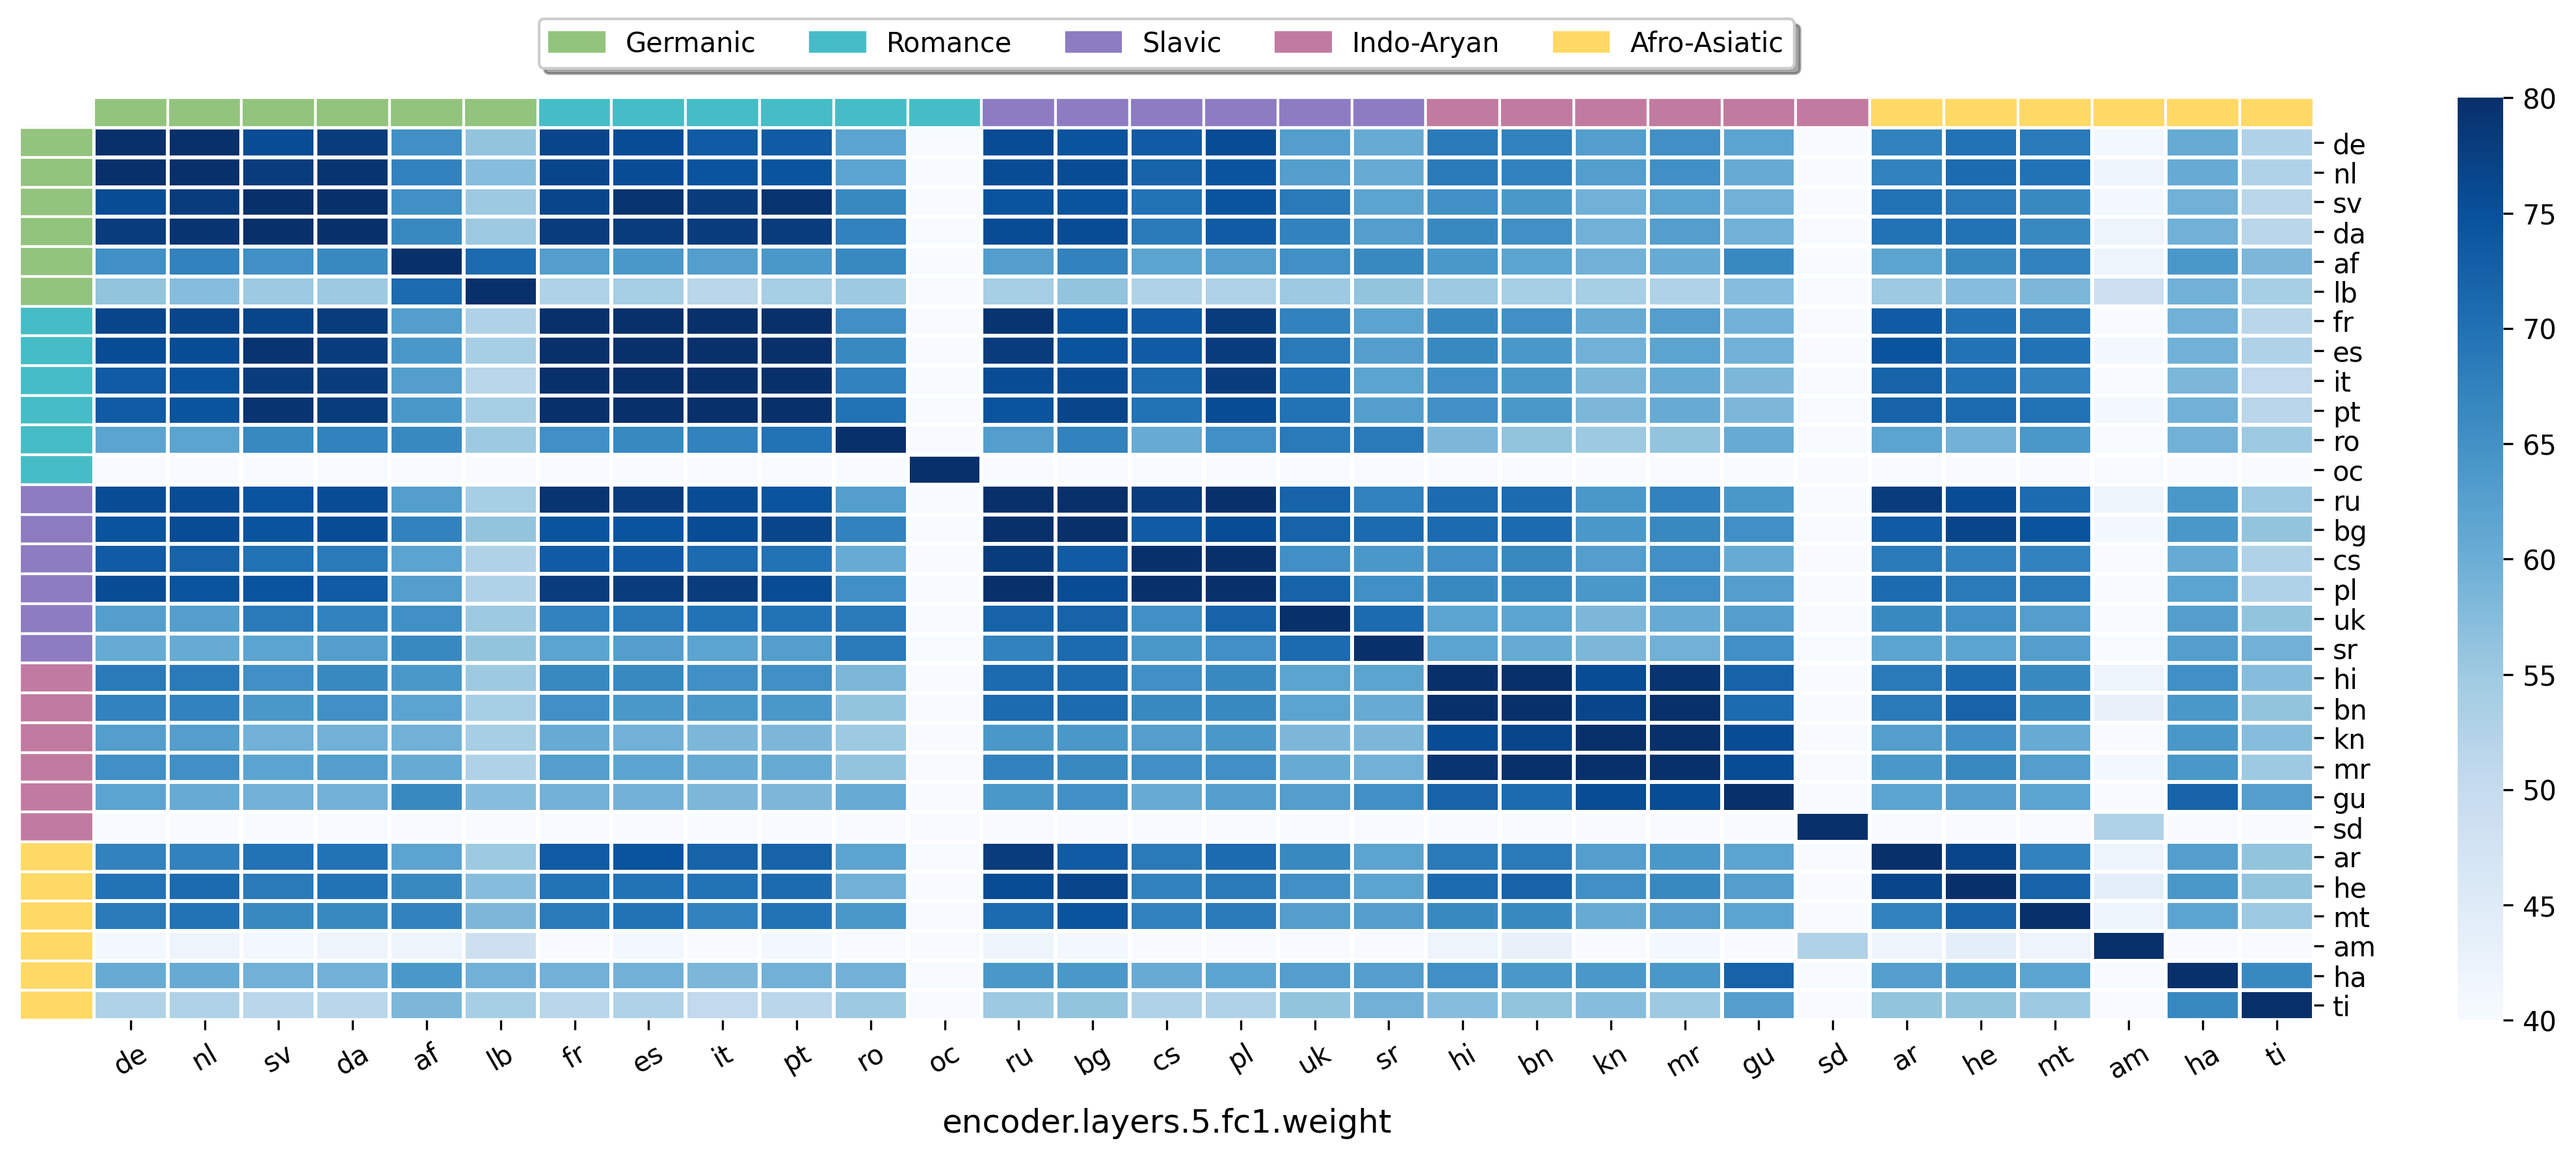

70.0  , 66.61111111111111
69.0  , 65.45977011494253


In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'encoder.layers.5.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks[src+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks[tgt+'-en'][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个


germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
enc_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

In [17]:
dec_ious = []

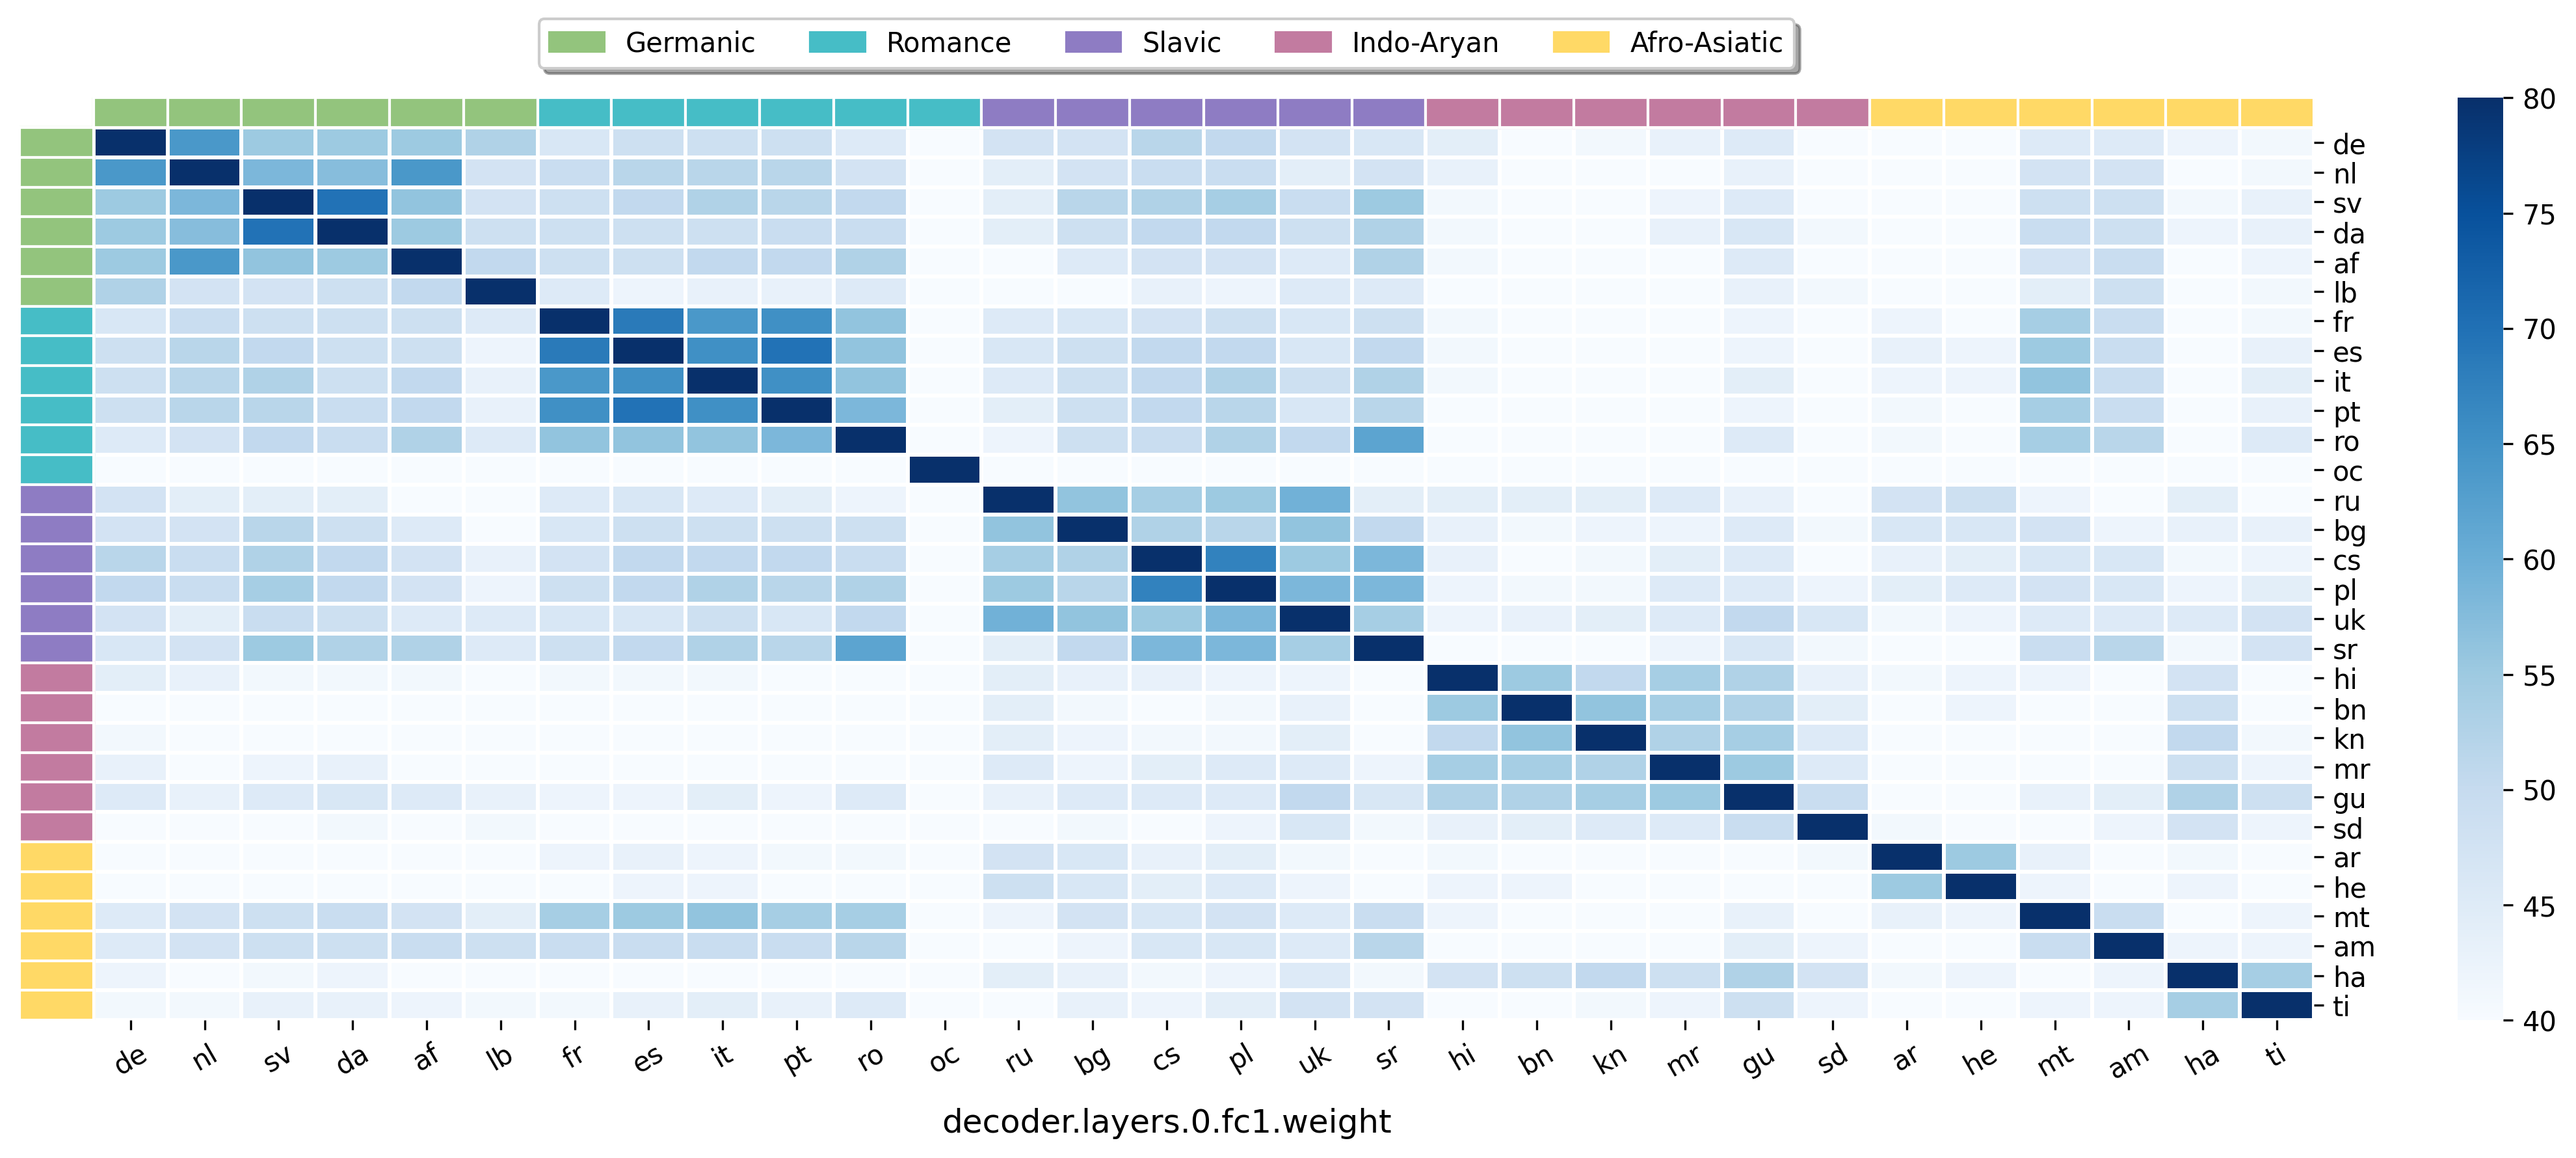

52.0  , 53.79555555555555
52.0  , 52.202298850574714


In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'decoder.layers.0.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks['en-'+src][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks['en-'+tgt][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个

germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
dec_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

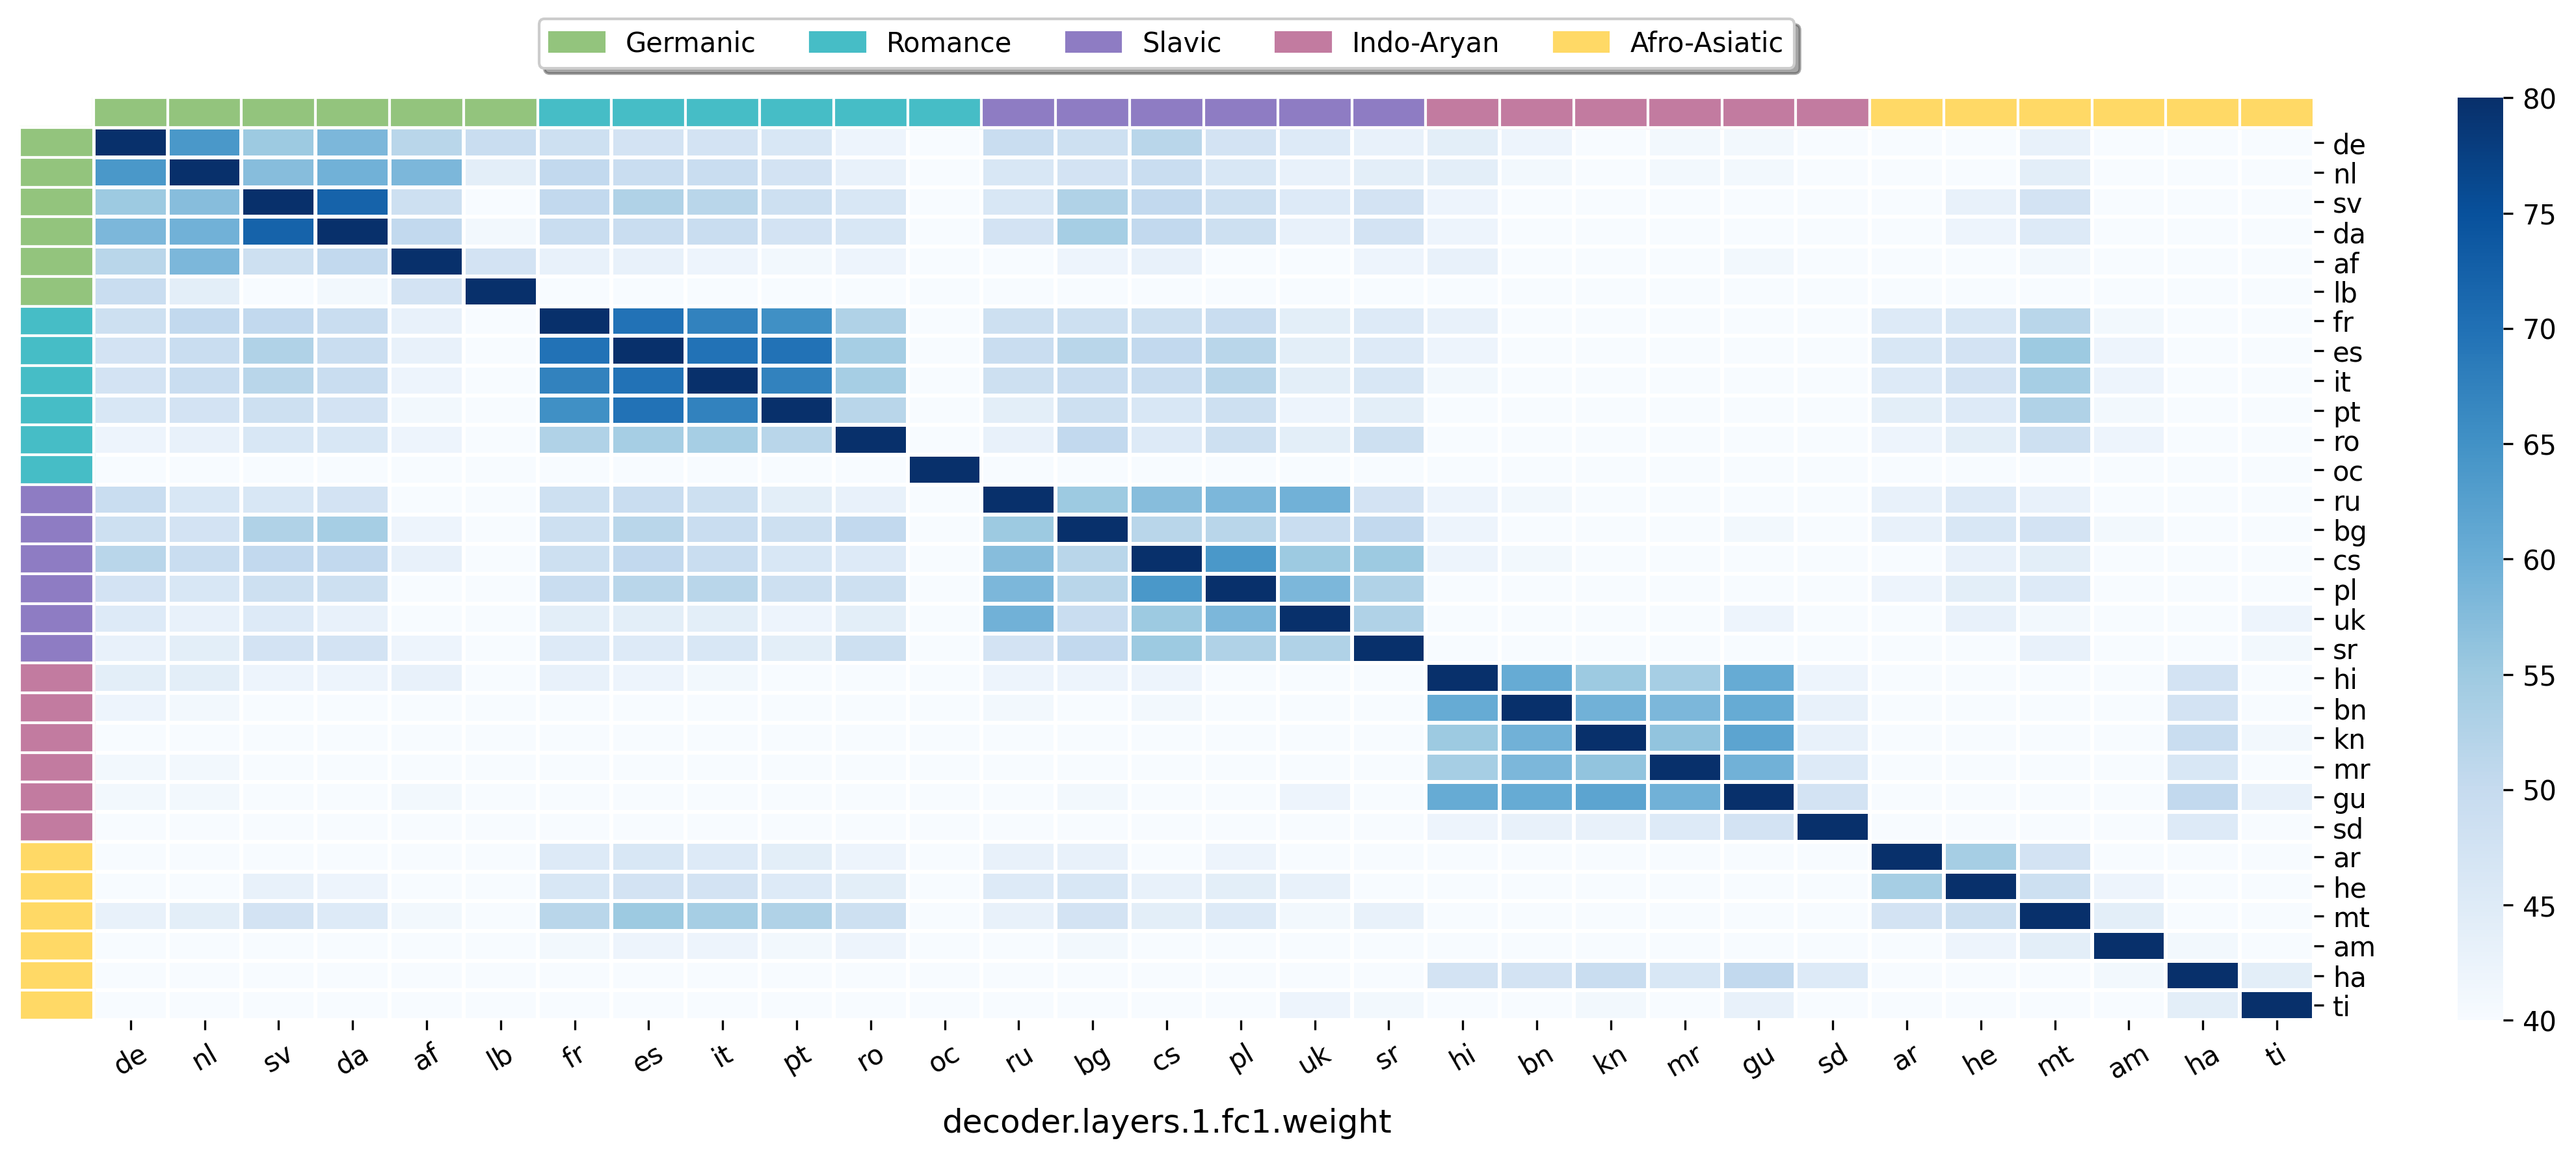

49.0  , 51.41777777777778
48.0  , 49.742528735632185


In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'decoder.layers.1.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks['en-'+src][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks['en-'+tgt][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个

germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
dec_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

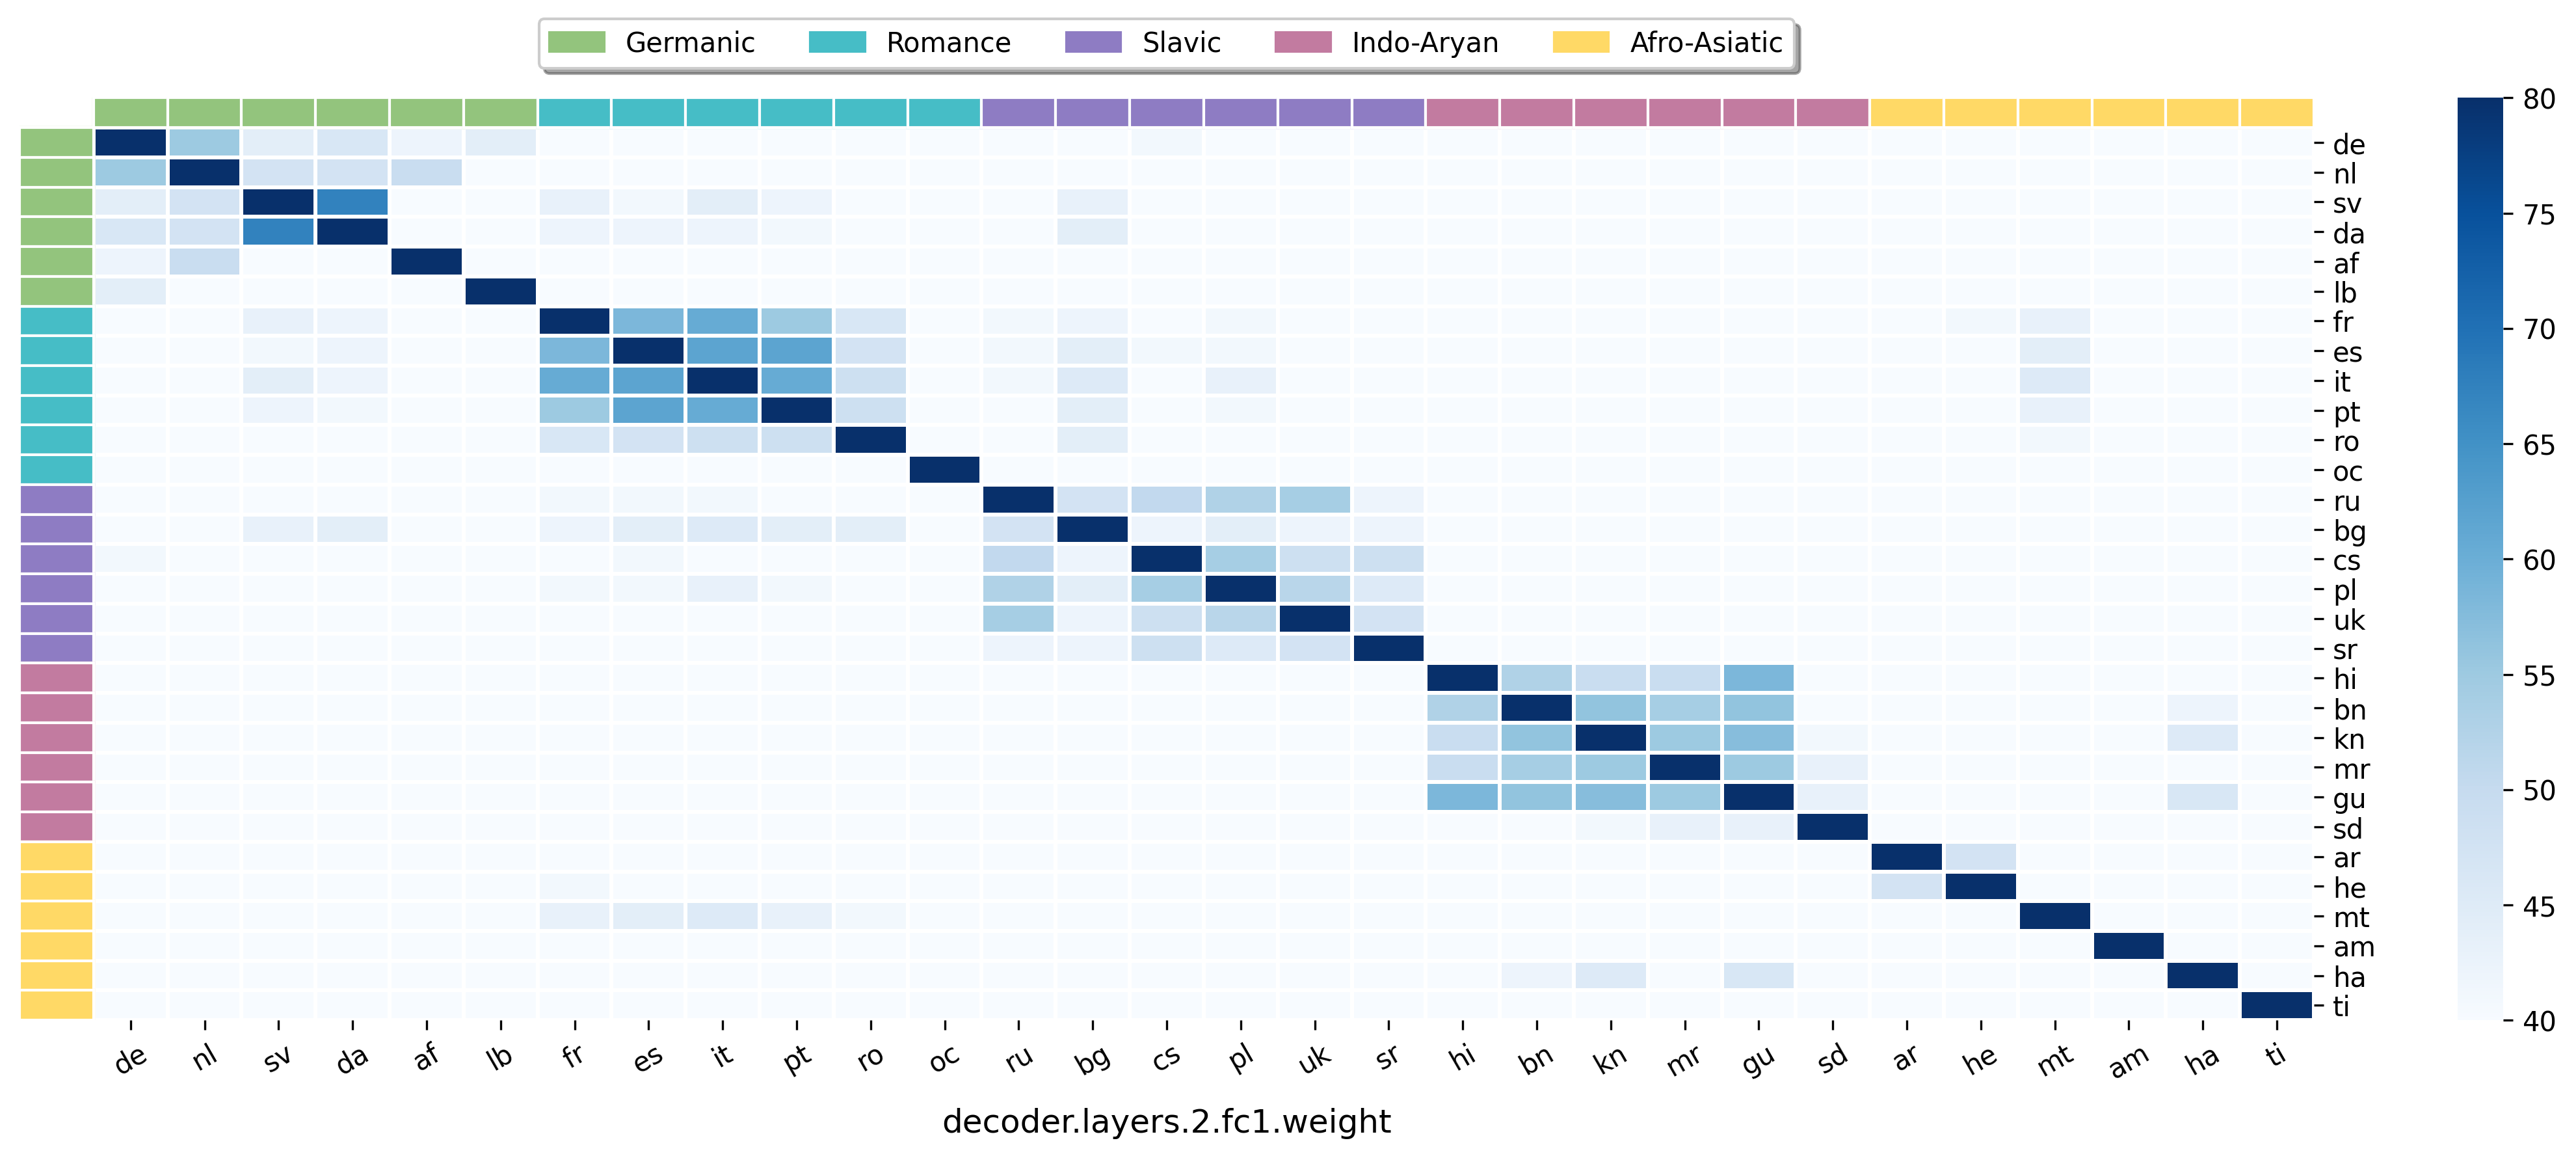

40.0  , 43.38444444444445
40.0  , 41.43218390804598


In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'decoder.layers.2.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks['en-'+src][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks['en-'+tgt][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个

germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
dec_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

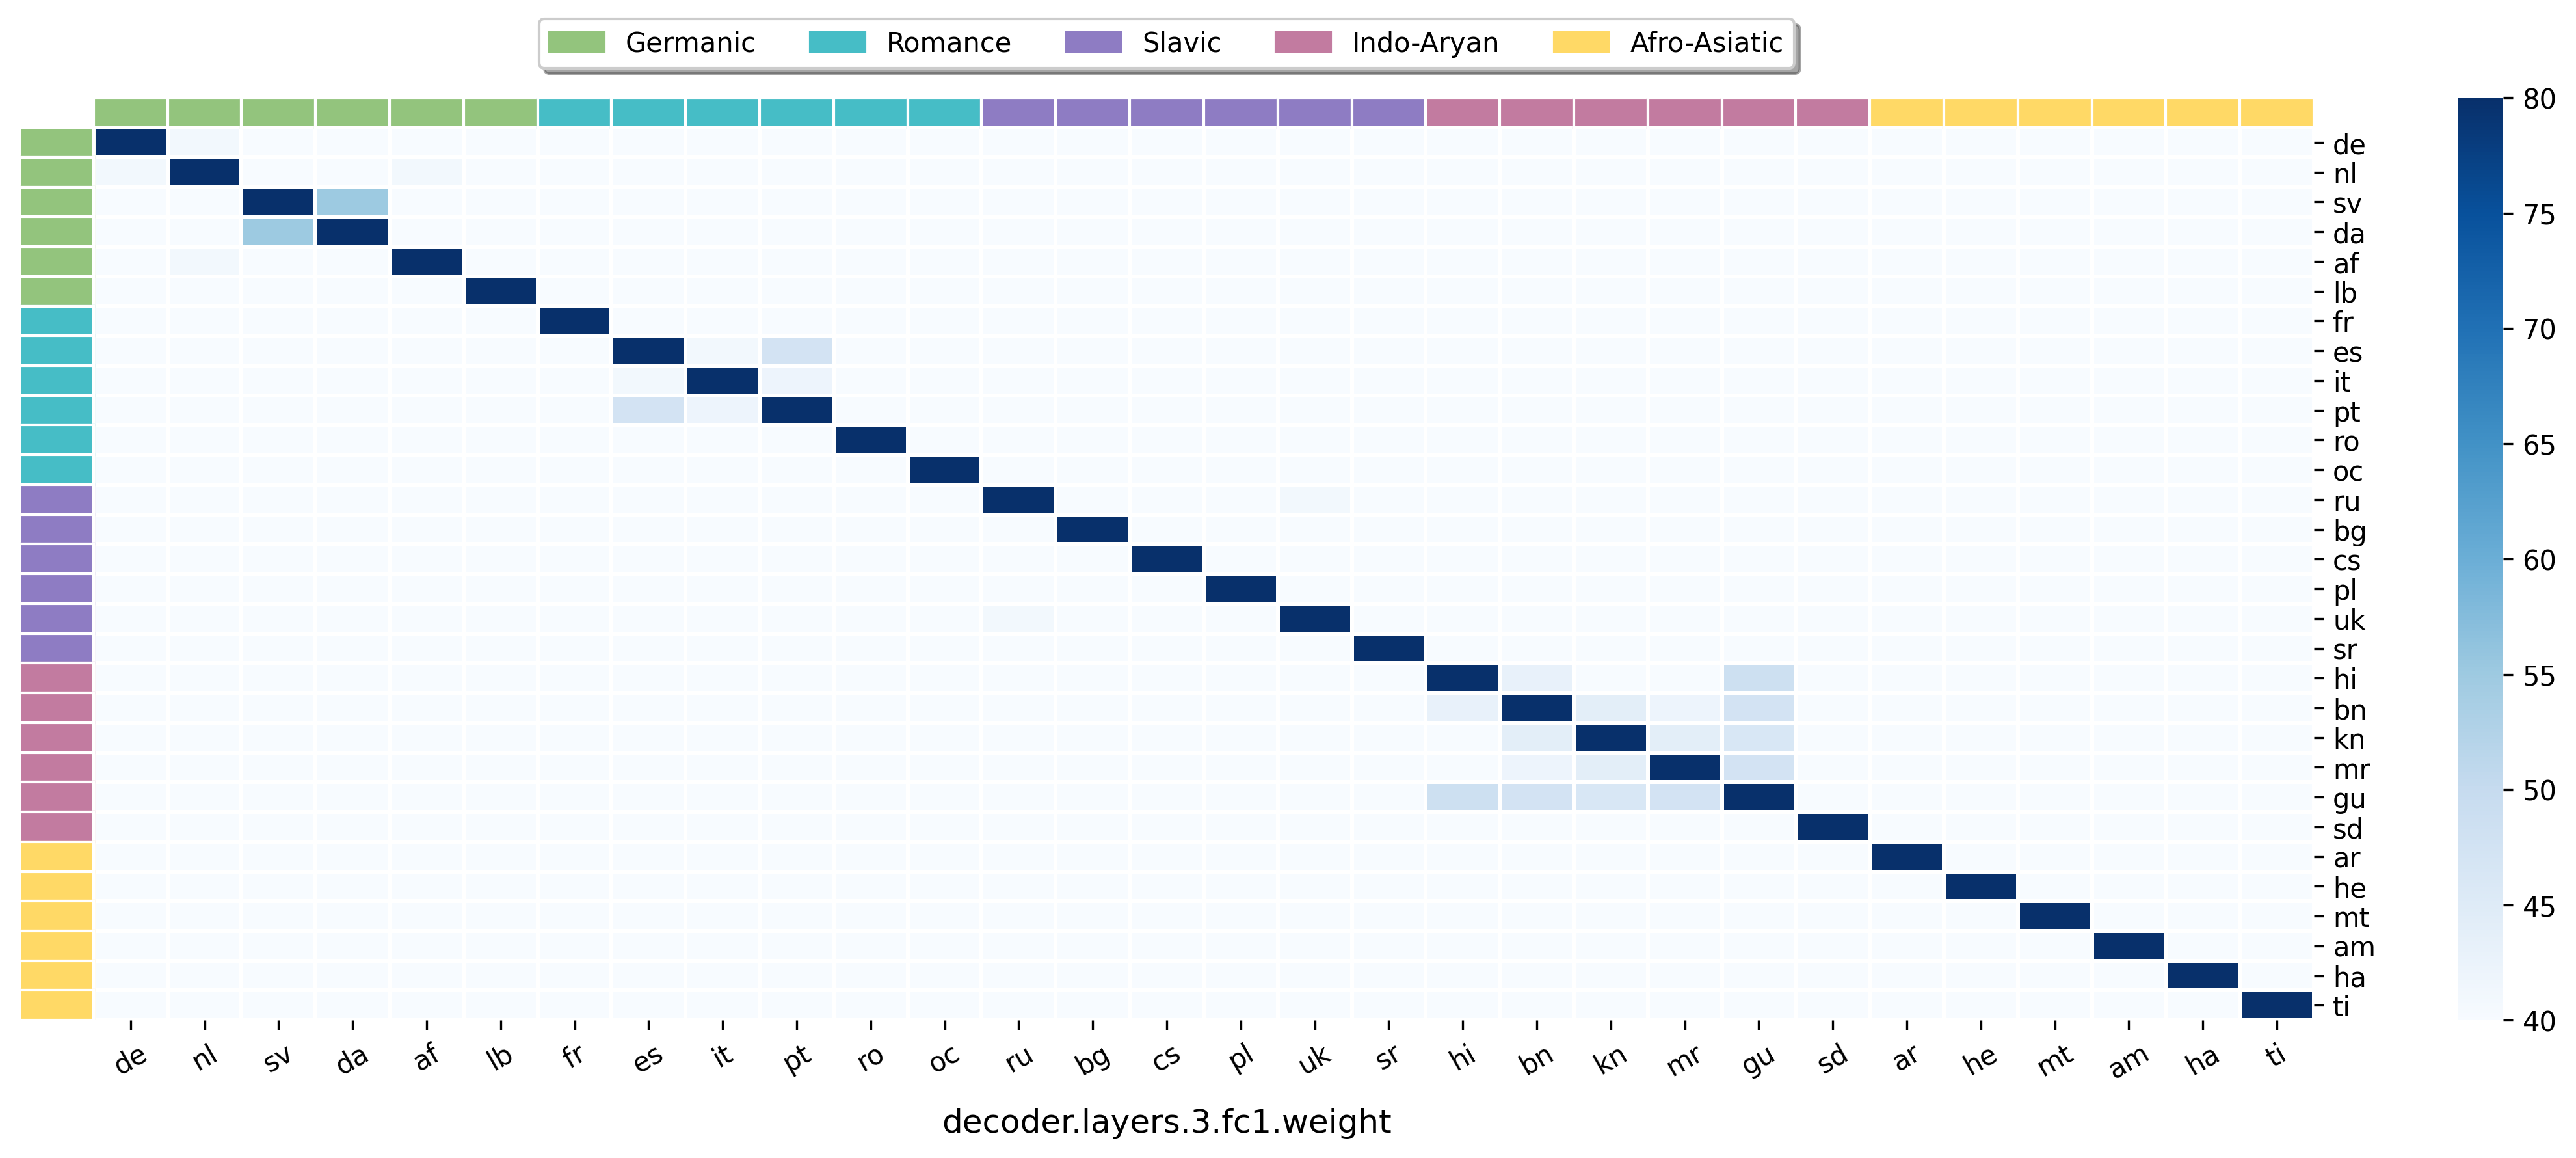

29.0  , 32.284444444444446
29.0  , 29.949425287356323


In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'decoder.layers.3.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks['en-'+src][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks['en-'+tgt][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个

germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
dec_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

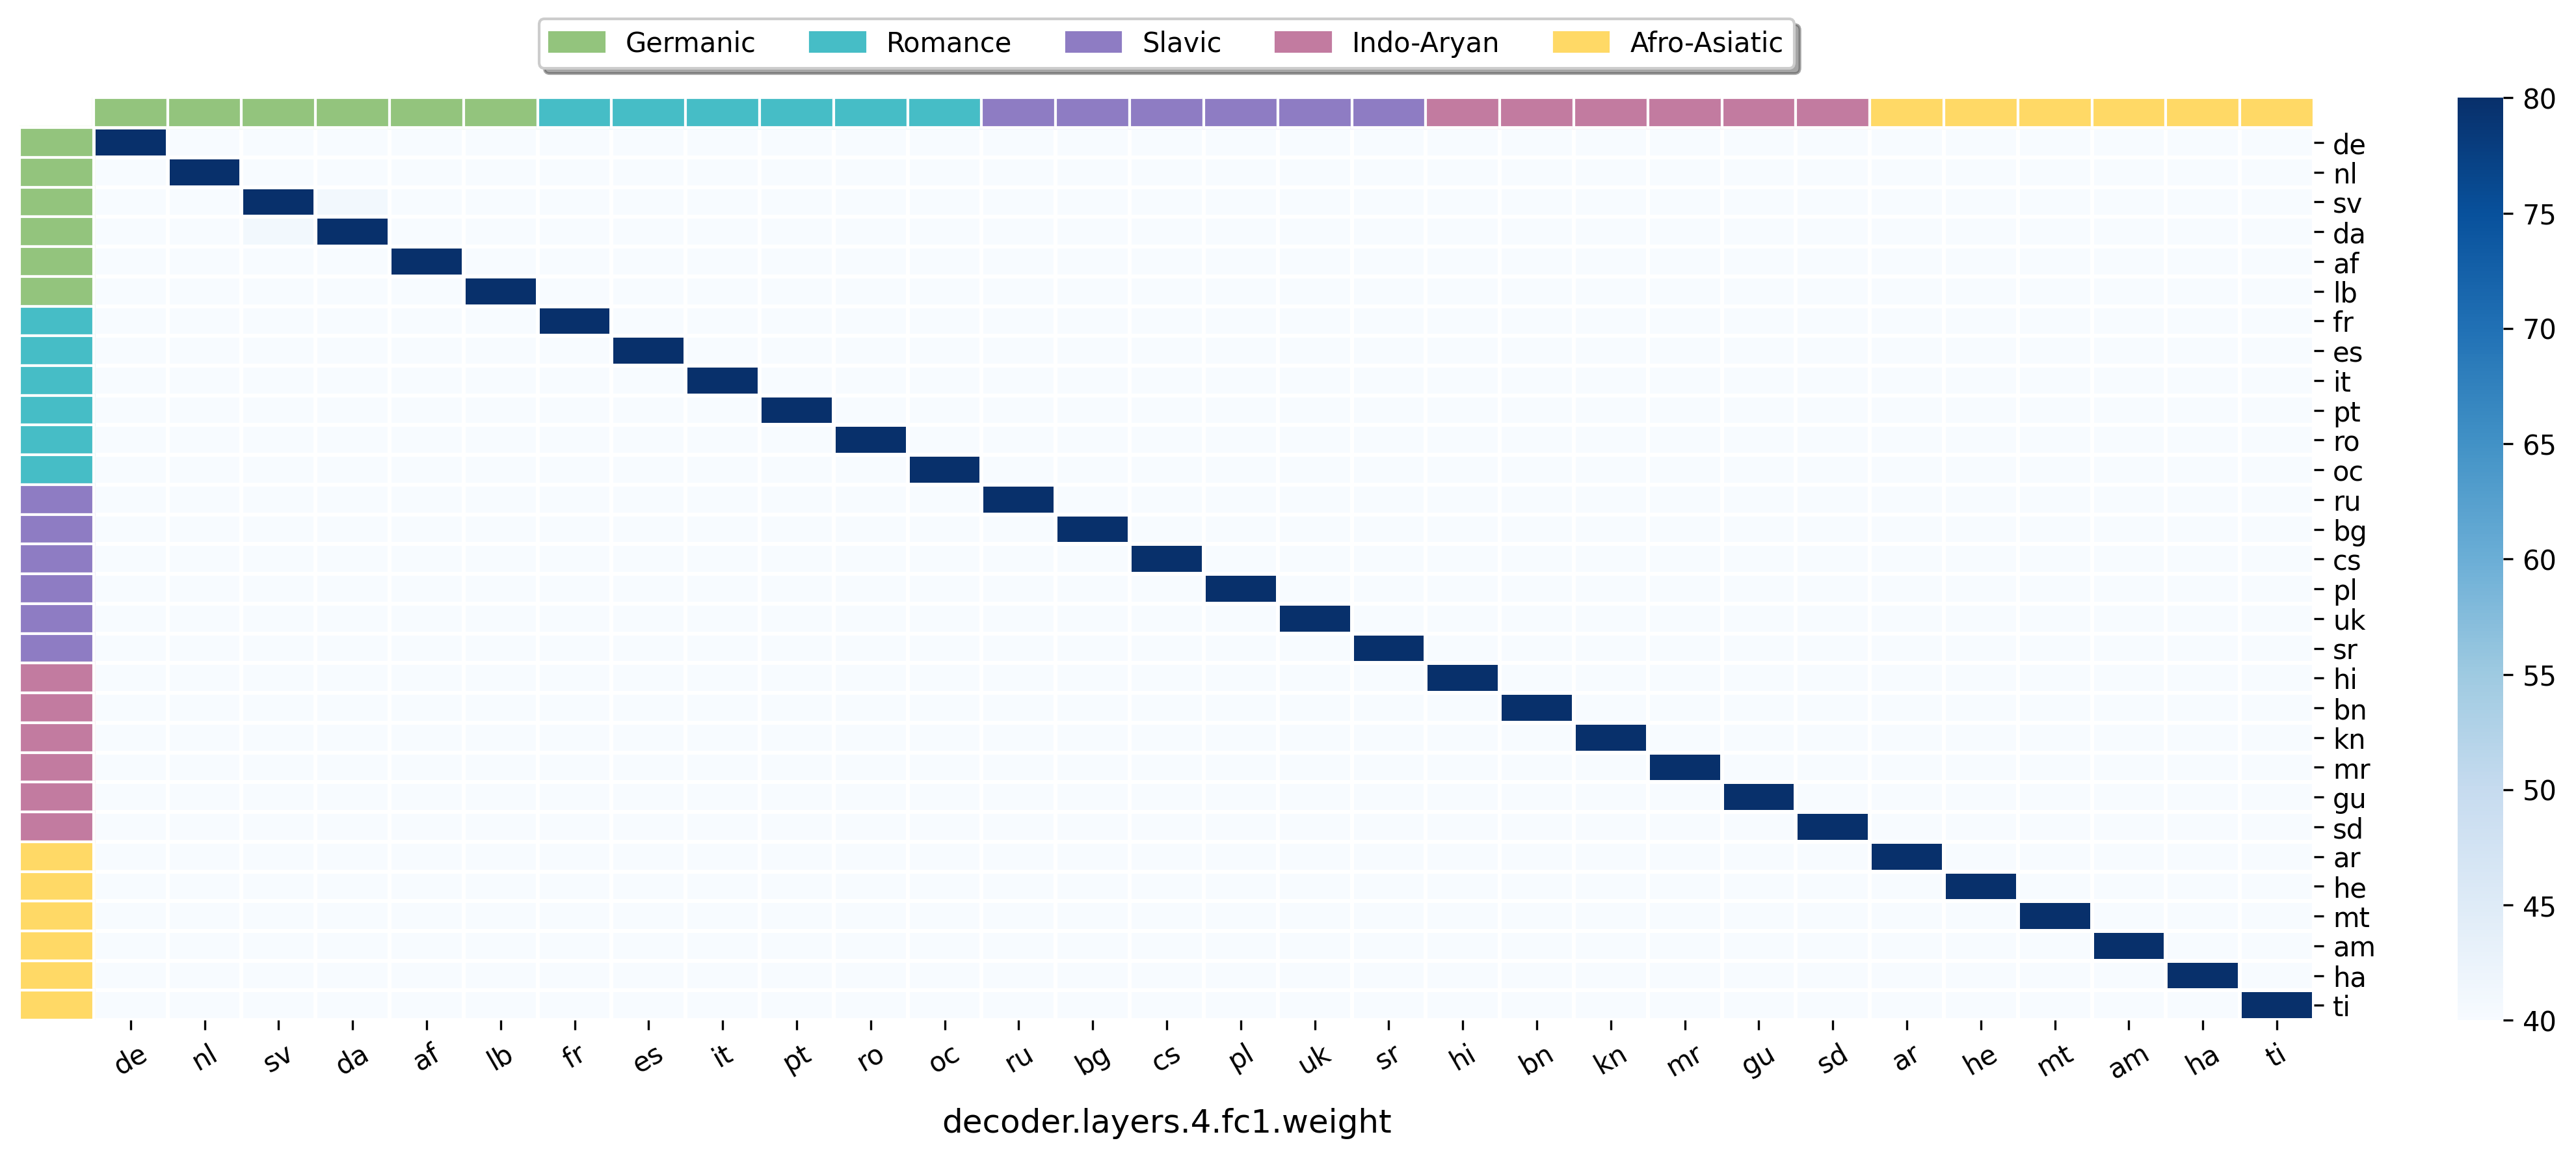

23.0  , 26.628888888888888
23.0  , 24.098850574712642


In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'decoder.layers.4.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks['en-'+src][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks['en-'+tgt][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个

germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
dec_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

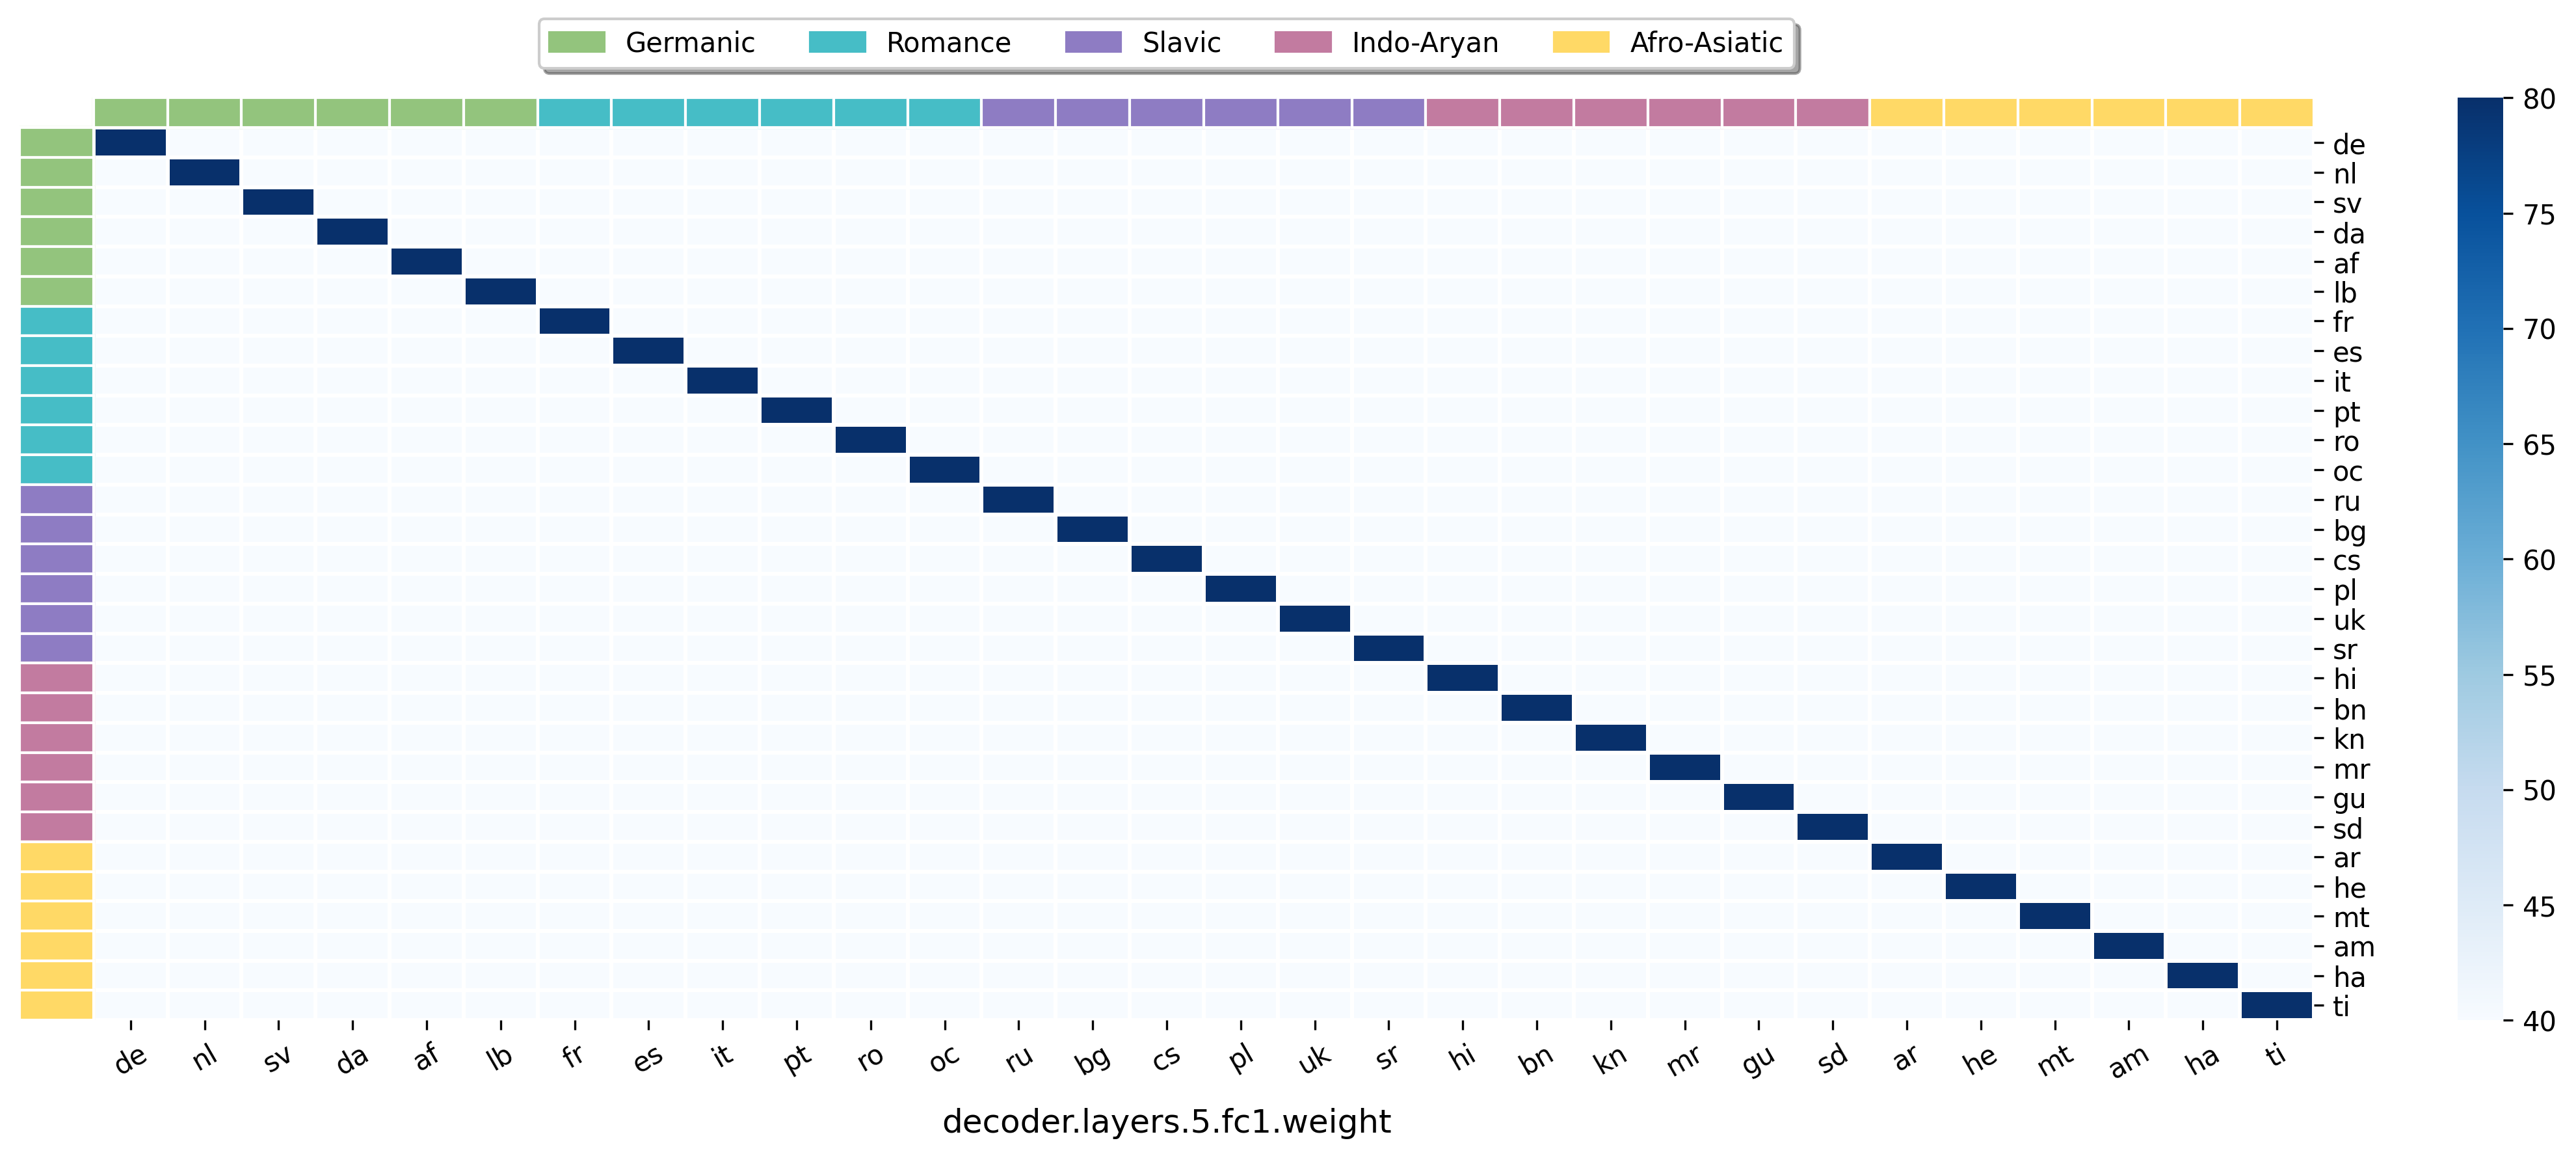

25.0  , 28.351111111111113
25.0  , 25.880459770114943


In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
layer = 'decoder.layers.5.fc1.weight'
df = pd.DataFrame(index=l_w, columns=l_w)
# Adding a new row and column with NaN values (for the colors)
df.loc[' '] = 0
df[' '] = 0
for src in l:
    for tgt in l:
        
        idx1 = ((masks['en-'+src][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        idx2 = ((masks['en-'+tgt][layer][:,0] == 1).nonzero(as_tuple=True)[0]).tolist()
        iou = calculate_iou_from_sets(set(idx1), 
                                set(idx2))
        df.loc[src, tgt] = iou
df = df * 100    
df = df.astype(int)
df_ori = copy.deepcopy(df)
df = df ** 1.25
df=(df-df.min())/(df.max()-df.min())
df = df *100
ax = axes
sns.heatmap(df, cmap='Blues', ax=ax, xticklabels=True, yticklabels=True, linewidths=1, vmin=40, vmax=80)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title(layer,y=-0.08,pad=-14)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks[1:])  # 从第二个刻度开始设置，跳过第一个
ax.set_yticks(yticks[1:])  # 同上
ax.set_xticklabels(l, rotation=30)  # 设置横轴标签，跳过第一个，旋转以改善显示
ax.set_yticklabels(l, rotation=0)   # 设置纵轴标签，跳过第一个

germanic_color = '#93c47d'
for i in range(1, 7):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=germanic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

romance_color = '#46bdc6'
for i in range(7,13):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=romance_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

slavic_color = '#8e7cc3'
for i in range(13,19):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=slavic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

aryan_color = '#c27ba0'
for i in range(19,25):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=aryan_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, color='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, color='white'))

afro_asiatic_color = '#ffd966'  
for i in range(25,31):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=True, color=afro_asiatic_color))
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, fill=False, edgecolor='white'))
    ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor='white'))

import matplotlib.patches as mpatches
legend_colors = ['#93c47d', '#46bdc6', '#8e7cc3', '#c27ba0', '#ffd966']
legend_labels = ['Germanic', 'Romance', 'Slavic', 'Indo-Aryan', 'Afro-Asiatic']
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(np.median(df_ori.values[1:,1:]), ' ,', df_ori.values[1:,1:].mean())
idx = np.triu_indices_from(df_ori.values[1:,1:], k=1)
triu = df_ori.values[1:,1:][idx]
dec_ious.append(triu)
print(np.median(triu), ' ,', triu.mean())

In [24]:
e = pd.DataFrame([i.tolist() for i in enc_ious])
e = pd.DataFrame(e.mean(axis=1).values, columns=['Encoder'])
#e['which']=['Enc_1', 'Enc_2', 'Enc_3', 'Enc_4', 'Enc_5', 'Enc_6']

d = pd.DataFrame([i.tolist() for i in dec_ious])
d = pd.DataFrame(d.mean(axis=1).values, columns=['Decoder'])
#d['which']=['Dec_1', 'Dec_2', 'Dec_3', 'Dec_4', 'Dec_5', 'Dec_6']

#overlap = pd.concat([e,d])

In [25]:
import matplotlib as mpl

<ipython-input-26-0c7f671c1617>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(['','1', '2', '3', '4', '5', '6'])


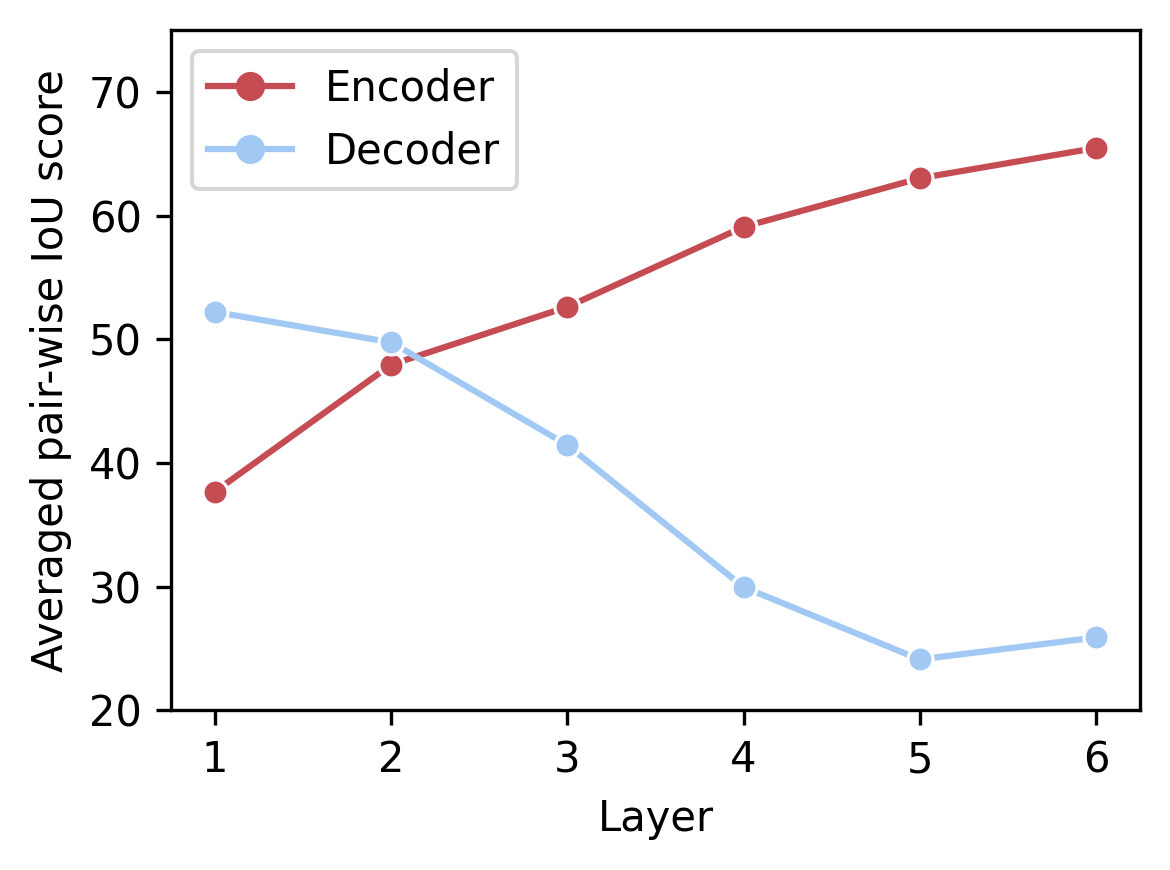

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 3)) 
sns.lineplot(data=e, ax=axs, markers=True, palette=['#c54c53'])
sns.lineplot(data=d, ax=axs, markers=True, palette=['#a1c9f4'])

axs.set_xticklabels(['','1', '2', '3', '4', '5', '6'])
plt.xlabel('Layer')
plt.ylabel('Averaged pair-wise IoU score')
plt.ylim([20,75])
plt.tight_layout()
plt.show()

In [30]:
current = pd.DataFrame(columns=['values', 'layer'])
for i in range(len(enc_ious)):
    now = pd.DataFrame(enc_ious[i], columns=['values'])
    now['layer'] = str(i)
    now[' ']='Encoder'
    current = pd.concat([current,now])


for i in range(len(dec_ious)):
    now = pd.DataFrame(dec_ious[i], columns=['values'])
    now['layer'] = str(i)
    now[' ']='Decoder'
    current = pd.concat([current,now])

Text(0, 0.5, 'Pair-wise IoU score')

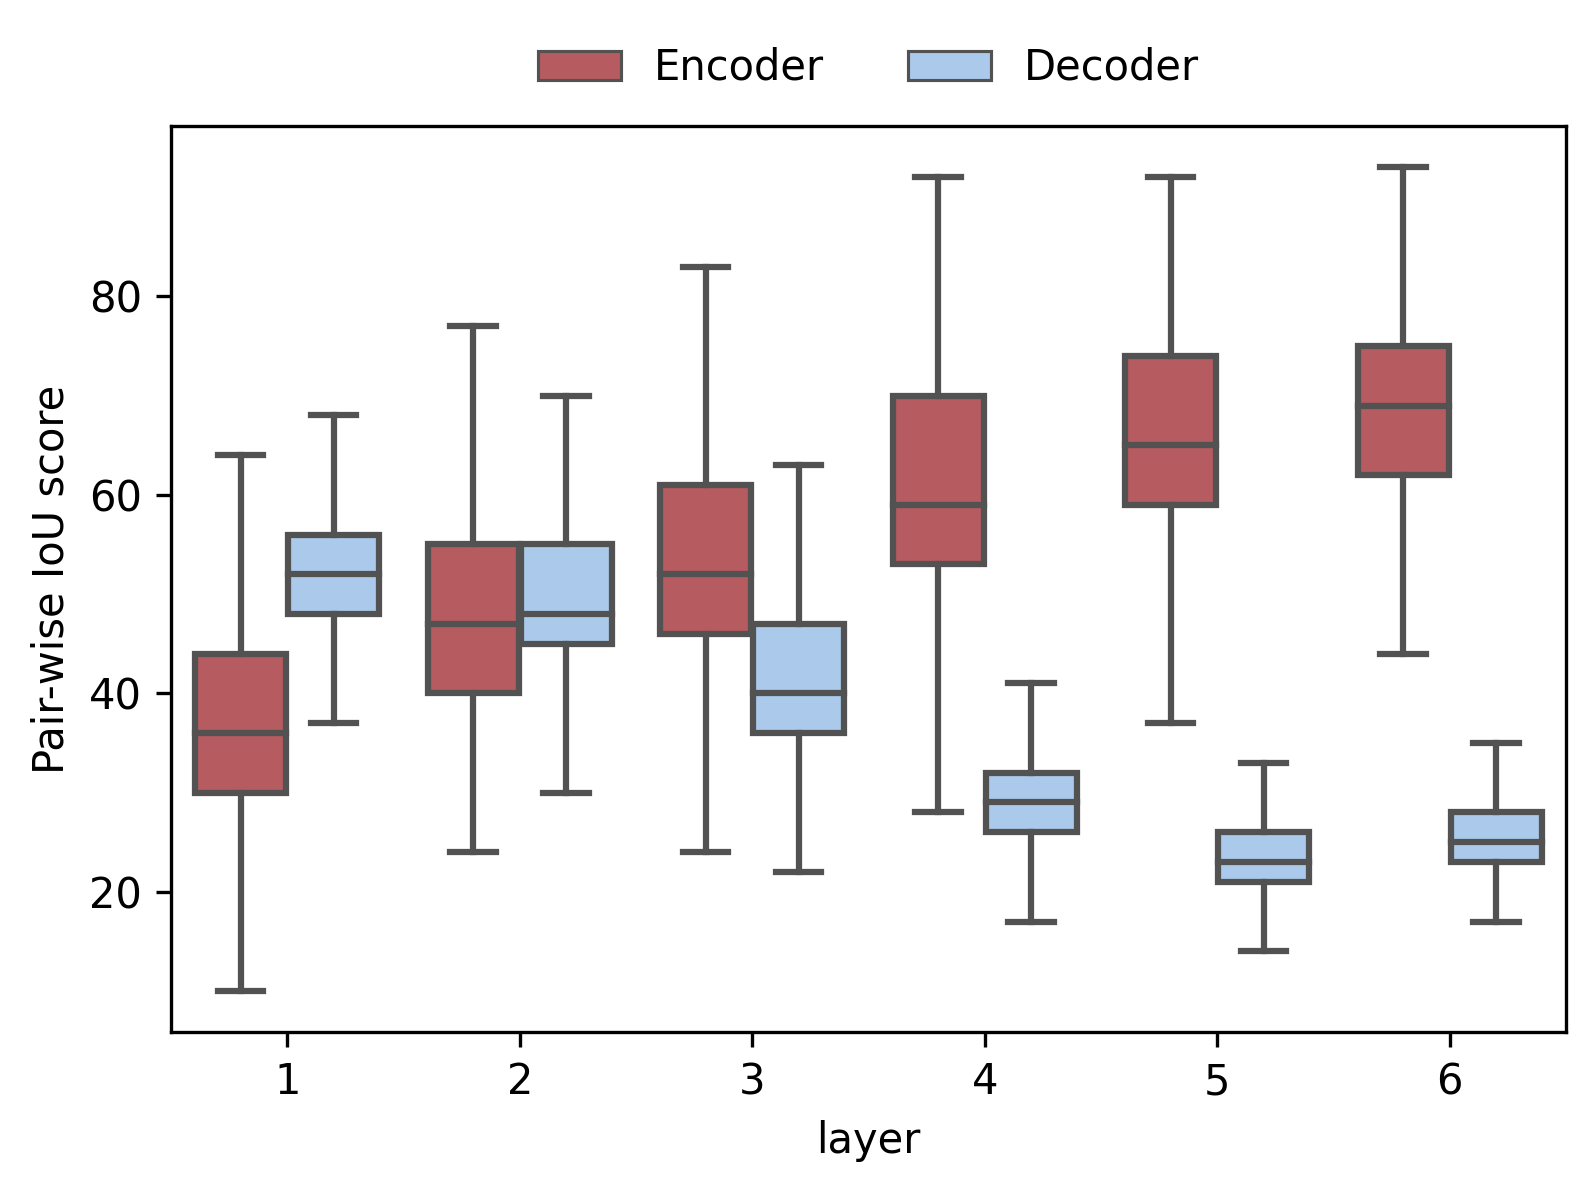

In [31]:
my_pal = {"Encoder": "#c54c53", "Decoder": "#a1c9f4"}
ax =sns.boxplot(data=current, x="layer", y="values", hue=" ",showfliers=False, palette=my_pal) # whis=0.5,

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
ax.set_xticklabels(['1', '2', '3', '4', '5', '6'])
plt.ylabel('Pair-wise IoU score')